# Currency Market Predictor - Recurrent Neural Netowork

Predicting EURUSD market

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [49]:
dataset = pd.read_csv('EURUSD_TechnicalIndicators.csv')
dataset.head(2)

Close  CloseTarget      MACD  Stochastics     ATR
0  1.3638       1.3630  0.001322    83.268482  0.0086
1  1.3630       1.3621  0.001137    80.155642  0.0100

#### Normalize

In [3]:
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm.head(2)

Close  CloseTarget      MACD  Stochastics       ATR
0  0.121300     0.119981  0.027770     0.336375 -0.076375
1  0.119872     0.118375  0.023829     0.305247 -0.049555

## Hyperparams

In [4]:
num_epochs = 10000

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 2616
The current configuration gives us 872 batches of 1 observations each one looking 3 steps in the past


## Train-Test split

In [5]:
datasetTrain = datasetNorm[dataset.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [6]:
datasetTrain.head(2)

Close  CloseTarget      MACD  Stochastics       ATR
0  0.121300     0.119981  0.027770     0.336375 -0.076375
1  0.119872     0.118375  0.023829     0.305247 -0.049555

In [7]:
datasetTest.head(2)

Close  CloseTarget      MACD  Stochastics       ATR
2514 -0.401285    -0.400104 -0.011668     0.343968 -0.168329
2515 -0.400214    -0.398140 -0.002441     0.385635 -0.105111

In [8]:
xTrain = datasetTrain[['Close','MACD','Stochastics','ATR']].as_matrix()
yTrain = datasetTrain['CloseTarget'].as_matrix()

In [9]:
print(xTrain[0:3],'\n',yTrain[0:3])

[[ 0.12130035  0.02777039  0.33637511 -0.07637498]
 [ 0.11987204  0.02382894  0.30524671 -0.04955505]
 [ 0.11826518  0.01903532  0.27022725 -0.13959337]] 
 [ 0.11998144  0.11837459  0.11587503]


In [10]:
xTest = datasetTest[['Close','MACD','Stochastics','ATR']].as_matrix()
yTest = datasetTest['CloseTarget'].as_matrix()

In [11]:
print(xTest[0:3],'\n',yTest[0:3])

[[-0.4012849  -0.01166827  0.34396806 -0.168329  ]
 [-0.40021366 -0.00244109  0.38563473 -0.10511061]
 [-0.39824973  0.0057795   0.46202362 -0.13193053]] 
 [-0.40010426 -0.39814032 -0.37332333]


## Visualize starting price data

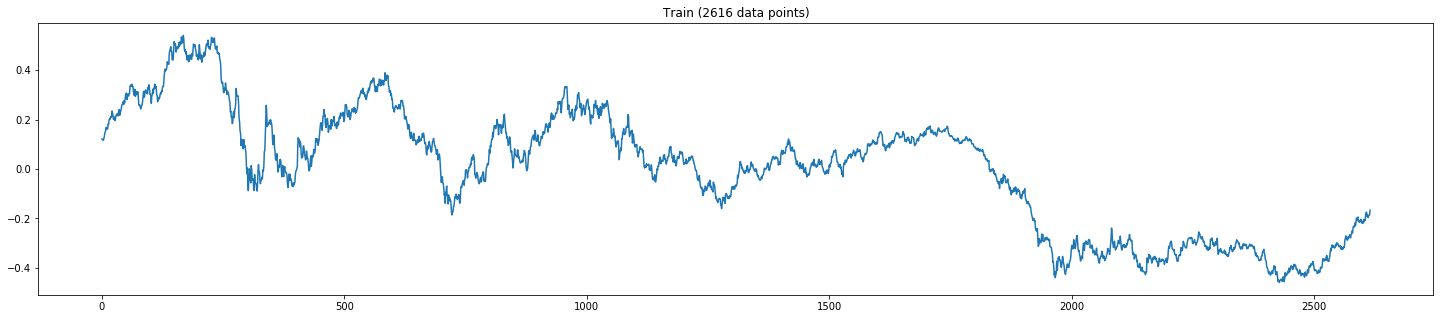

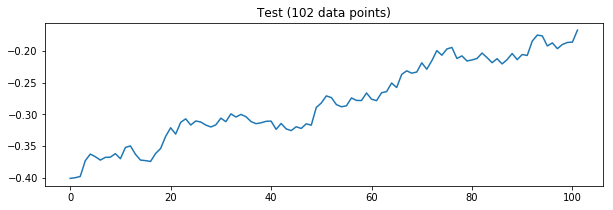

In [12]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

## Placeholders

In [13]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases
Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output

We need 2 pairs of W and b

In [14]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack

In [15]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [16]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [17]:
states_series = tf.transpose(states_series,[1,0,2])

## Backward pass - Output

In [18]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Weights and bias out

In [19]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

## Prediction, Loss & Optimizer

In [20]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [21]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [22]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][-1]) #The last one

Epoch 0
Step 0 - Loss: 0.000036
Step 50 - Loss: 0.002573
Step 100 - Loss: 0.034110
Step 150 - Loss: 0.003183
Step 200 - Loss: 0.003237
Step 250 - Loss: 0.002256
Step 300 - Loss: 0.001384
Step 350 - Loss: 0.000350
Step 400 - Loss: 0.000643
Step 450 - Loss: 0.001835
Step 500 - Loss: 0.000007
Step 550 - Loss: 0.000733
Step 600 - Loss: 0.000013
Step 650 - Loss: 0.000013
Step 700 - Loss: 0.000291
Step 750 - Loss: 0.000091
Step 800 - Loss: 0.000072
Step 850 - Loss: 0.000147
Epoch 1
Step 0 - Loss: 0.003522
Step 50 - Loss: 0.002962
Step 100 - Loss: 0.003122
Step 150 - Loss: 0.006866
Step 200 - Loss: 0.000003
Step 250 - Loss: 0.000135
Step 300 - Loss: 0.000185
Step 350 - Loss: 0.000066
Step 400 - Loss: 0.000233
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000099
Step 550 - Loss: 0.000030
Step 600 - Loss: 0.000002
Step 650 - Loss: 0.000221
Step 700 - Loss: 0.000558
Step 750 - Loss: 0.000040
Step 800 - Loss: 0.000045
Step 850 - Loss: 0.000053
Epoch 2
Step 0 - Loss: 0.000492
Step 50 - Loss: 0.0036

Step 400 - Loss: 0.000093
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000056
Step 550 - Loss: 0.000195
Step 600 - Loss: 0.000059
Step 650 - Loss: 0.000306
Step 700 - Loss: 0.000735
Step 750 - Loss: 0.000164
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000021
Epoch 18
Step 0 - Loss: 0.001138
Step 50 - Loss: 0.001710
Step 100 - Loss: 0.000008
Step 150 - Loss: 0.000726
Step 200 - Loss: 0.000282
Step 250 - Loss: 0.000035
Step 300 - Loss: 0.000780
Step 350 - Loss: 0.000130
Step 400 - Loss: 0.000089
Step 450 - Loss: 0.000134
Step 500 - Loss: 0.000056
Step 550 - Loss: 0.000191
Step 600 - Loss: 0.000058
Step 650 - Loss: 0.000307
Step 700 - Loss: 0.000753
Step 750 - Loss: 0.000155
Step 800 - Loss: 0.000007
Step 850 - Loss: 0.000020
Epoch 19
Step 0 - Loss: 0.001110
Step 50 - Loss: 0.001723
Step 100 - Loss: 0.000021
Step 150 - Loss: 0.000668
Step 200 - Loss: 0.000284
Step 250 - Loss: 0.000027
Step 300 - Loss: 0.000727
Step 350 - Loss: 0.000126
Step 400 - Loss: 0.000082
Step 450 - Loss: 0.000142


Step 750 - Loss: 0.000075
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000021
Epoch 35
Step 0 - Loss: 0.000839
Step 50 - Loss: 0.001747
Step 100 - Loss: 0.000559
Step 150 - Loss: 0.000252
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000323
Step 350 - Loss: 0.000036
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000201
Step 500 - Loss: 0.000074
Step 550 - Loss: 0.000183
Step 600 - Loss: 0.000043
Step 650 - Loss: 0.000128
Step 700 - Loss: 0.000989
Step 750 - Loss: 0.000071
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000021
Epoch 36
Step 0 - Loss: 0.000801
Step 50 - Loss: 0.001787
Step 100 - Loss: 0.000542
Step 150 - Loss: 0.000228
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000350
Step 350 - Loss: 0.000034
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000207
Step 500 - Loss: 0.000079
Step 550 - Loss: 0.000185
Step 600 - Loss: 0.000042
Step 650 - Loss: 0.000117
Step 700 - Loss: 0.000973
Step 750 - Loss: 0.000074
Step 800 - Loss: 0.000001


Step 150 - Loss: 0.000193
Step 200 - Loss: 0.000164
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000242
Step 350 - Loss: 0.000013
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000288
Step 500 - Loss: 0.000055
Step 550 - Loss: 0.000189
Step 600 - Loss: 0.000047
Step 650 - Loss: 0.000066
Step 700 - Loss: 0.000909
Step 750 - Loss: 0.000074
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000036
Epoch 53
Step 0 - Loss: 0.000744
Step 50 - Loss: 0.001631
Step 100 - Loss: 0.001018
Step 150 - Loss: 0.000194
Step 200 - Loss: 0.000159
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000235
Step 350 - Loss: 0.000013
Step 400 - Loss: 0.000002
Step 450 - Loss: 0.000291
Step 500 - Loss: 0.000054
Step 550 - Loss: 0.000188
Step 600 - Loss: 0.000048
Step 650 - Loss: 0.000065
Step 700 - Loss: 0.000907
Step 750 - Loss: 0.000075
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000037
Epoch 54
Step 0 - Loss: 0.000738
Step 50 - Loss: 0.001625
Step 100 - Loss: 0.001044
Step 150 - Loss: 0.000196
Step 200 - Loss: 0.000154


Step 450 - Loss: 0.000270
Step 500 - Loss: 0.000033
Step 550 - Loss: 0.000191
Step 600 - Loss: 0.000051
Step 650 - Loss: 0.000079
Step 700 - Loss: 0.000854
Step 750 - Loss: 0.000092
Step 800 - Loss: 0.000015
Step 850 - Loss: 0.000053
Epoch 70
Step 0 - Loss: 0.000616
Step 50 - Loss: 0.001484
Step 100 - Loss: 0.001441
Step 150 - Loss: 0.000255
Step 200 - Loss: 0.000149
Step 250 - Loss: 0.000004
Step 300 - Loss: 0.000136
Step 350 - Loss: 0.000018
Step 400 - Loss: 0.000000
Step 450 - Loss: 0.000267
Step 500 - Loss: 0.000031
Step 550 - Loss: 0.000191
Step 600 - Loss: 0.000051
Step 650 - Loss: 0.000082
Step 700 - Loss: 0.000847
Step 750 - Loss: 0.000093
Step 800 - Loss: 0.000016
Step 850 - Loss: 0.000054
Epoch 71
Step 0 - Loss: 0.000607
Step 50 - Loss: 0.001474
Step 100 - Loss: 0.001470
Step 150 - Loss: 0.000258
Step 200 - Loss: 0.000149
Step 250 - Loss: 0.000004
Step 300 - Loss: 0.000130
Step 350 - Loss: 0.000019
Step 400 - Loss: 0.000000
Step 450 - Loss: 0.000263
Step 500 - Loss: 0.000030


Step 850 - Loss: 0.000089
Epoch 87
Step 0 - Loss: 0.000469
Step 50 - Loss: 0.001268
Step 100 - Loss: 0.001927
Step 150 - Loss: 0.000293
Step 200 - Loss: 0.000198
Step 250 - Loss: 0.000022
Step 300 - Loss: 0.000097
Step 350 - Loss: 0.000027
Step 400 - Loss: 0.000001
Step 450 - Loss: 0.000221
Step 500 - Loss: 0.000013
Step 550 - Loss: 0.000200
Step 600 - Loss: 0.000048
Step 650 - Loss: 0.000087
Step 700 - Loss: 0.000596
Step 750 - Loss: 0.000101
Step 800 - Loss: 0.000047
Step 850 - Loss: 0.000092
Epoch 88
Step 0 - Loss: 0.000469
Step 50 - Loss: 0.001247
Step 100 - Loss: 0.001982
Step 150 - Loss: 0.000301
Step 200 - Loss: 0.000192
Step 250 - Loss: 0.000026
Step 300 - Loss: 0.000087
Step 350 - Loss: 0.000027
Step 400 - Loss: 0.000001
Step 450 - Loss: 0.000216
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000200
Step 600 - Loss: 0.000047
Step 650 - Loss: 0.000090
Step 700 - Loss: 0.000551
Step 750 - Loss: 0.000103
Step 800 - Loss: 0.000050
Step 850 - Loss: 0.000096
Epoch 89
Step 0 - Loss: 0.

Step 250 - Loss: 0.000041
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000026
Step 400 - Loss: 0.000002
Step 450 - Loss: 0.000179
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000190
Step 600 - Loss: 0.000044
Step 650 - Loss: 0.000133
Step 700 - Loss: 0.000411
Step 750 - Loss: 0.000101
Step 800 - Loss: 0.000084
Step 850 - Loss: 0.000130
Epoch 105
Step 0 - Loss: 0.000294
Step 50 - Loss: 0.000981
Step 100 - Loss: 0.002575
Step 150 - Loss: 0.000269
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000024
Step 300 - Loss: 0.000093
Step 350 - Loss: 0.000023
Step 400 - Loss: 0.000002
Step 450 - Loss: 0.000190
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000197
Step 600 - Loss: 0.000046
Step 650 - Loss: 0.000113
Step 700 - Loss: 0.000381
Step 750 - Loss: 0.000090
Step 800 - Loss: 0.000085
Step 850 - Loss: 0.000135
Epoch 106
Step 0 - Loss: 0.000331
Step 50 - Loss: 0.000952
Step 100 - Loss: 0.002518
Step 150 - Loss: 0.000256
Step 200 - Loss: 0.000207
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.00007

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000045
Step 650 - Loss: 0.000111
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000082
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000184
Epoch 122
Step 0 - Loss: 0.000194
Step 50 - Loss: 0.000307
Step 100 - Loss: 0.003227
Step 150 - Loss: 0.000129
Step 200 - Loss: 0.000277
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000047
Step 400 - Loss: 0.000007
Step 450 - Loss: 0.000157
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000045
Step 650 - Loss: 0.000117
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000083
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000182
Epoch 123
Step 0 - Loss: 0.000186
Step 50 - Loss: 0.000395
Step 100 - Loss: 0.003426
Step 150 - Loss: 0.000123
Step 200 - Loss: 0.000292
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000046
Step 400 - Loss: 0.000009
Step 450 - Loss: 0.000164
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.00014

Step 750 - Loss: 0.000088
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000198
Epoch 139
Step 0 - Loss: 0.000116
Step 50 - Loss: 0.000397
Step 100 - Loss: 0.003951
Step 150 - Loss: 0.000148
Step 200 - Loss: 0.000256
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000070
Step 400 - Loss: 0.000015
Step 450 - Loss: 0.000144
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000095
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000072
Step 700 - Loss: 0.000200
Step 750 - Loss: 0.000089
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000183
Epoch 140
Step 0 - Loss: 0.000120
Step 50 - Loss: 0.000280
Step 100 - Loss: 0.003623
Step 150 - Loss: 0.000144
Step 200 - Loss: 0.000256
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000066
Step 400 - Loss: 0.000017
Step 450 - Loss: 0.000152
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000099
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000070
Step 700 - Loss: 0.000188
Step 750 - Loss: 0.000088
Step 800 - Loss: 0.00011

Step 200 - Loss: 0.000289
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000078
Step 400 - Loss: 0.000021
Step 450 - Loss: 0.000145
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000108
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000047
Step 700 - Loss: 0.000180
Step 750 - Loss: 0.000089
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000161
Epoch 157
Step 0 - Loss: 0.000109
Step 50 - Loss: 0.000131
Step 100 - Loss: 0.003442
Step 150 - Loss: 0.000057
Step 200 - Loss: 0.000306
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000088
Step 400 - Loss: 0.000015
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000098
Step 600 - Loss: 0.000038
Step 650 - Loss: 0.000061
Step 700 - Loss: 0.000192
Step 750 - Loss: 0.000086
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000163
Epoch 158
Step 0 - Loss: 0.000099
Step 50 - Loss: 0.000175
Step 100 - Loss: 0.003588
Step 150 - Loss: 0.000072
Step 200 - Loss: 0.000283
Step 250 - Loss: 0.00006

Step 500 - Loss: 0.000002
Step 550 - Loss: 0.000127
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000035
Step 700 - Loss: 0.000189
Step 750 - Loss: 0.000089
Step 800 - Loss: 0.000133
Step 850 - Loss: 0.000162
Epoch 174
Step 0 - Loss: 0.000074
Step 50 - Loss: 0.000271
Step 100 - Loss: 0.003193
Step 150 - Loss: 0.000140
Step 200 - Loss: 0.000266
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000113
Step 400 - Loss: 0.000029
Step 450 - Loss: 0.000136
Step 500 - Loss: 0.000002
Step 550 - Loss: 0.000126
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000035
Step 700 - Loss: 0.000206
Step 750 - Loss: 0.000090
Step 800 - Loss: 0.000135
Step 850 - Loss: 0.000169
Epoch 175
Step 0 - Loss: 0.000067
Step 50 - Loss: 0.000261
Step 100 - Loss: 0.003120
Step 150 - Loss: 0.000112
Step 200 - Loss: 0.000292
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000113
Step 400 - Loss: 0.000030
Step 450 - Loss: 0.000138
Step 500 - Loss: 0.000002
Step 550 - Loss: 0.00012

Step 750 - Loss: 0.000097
Step 800 - Loss: 0.000137
Step 850 - Loss: 0.000157
Epoch 191
Step 0 - Loss: 0.000063
Step 50 - Loss: 0.000184
Step 100 - Loss: 0.003043
Step 150 - Loss: 0.000070
Step 200 - Loss: 0.000282
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000133
Step 400 - Loss: 0.000030
Step 450 - Loss: 0.000135
Step 500 - Loss: 0.000002
Step 550 - Loss: 0.000132
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000026
Step 700 - Loss: 0.000207
Step 750 - Loss: 0.000093
Step 800 - Loss: 0.000140
Step 850 - Loss: 0.000160
Epoch 192
Step 0 - Loss: 0.000061
Step 50 - Loss: 0.000251
Step 100 - Loss: 0.002939
Step 150 - Loss: 0.000095
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000119
Step 400 - Loss: 0.000033
Step 450 - Loss: 0.000140
Step 500 - Loss: 0.000002
Step 550 - Loss: 0.000131
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000024
Step 700 - Loss: 0.000214
Step 750 - Loss: 0.000095
Step 800 - Loss: 0.00013

Step 150 - Loss: 0.000067
Step 200 - Loss: 0.000263
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000150
Step 400 - Loss: 0.000035
Step 450 - Loss: 0.000137
Step 500 - Loss: 0.000002
Step 550 - Loss: 0.000136
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000021
Step 700 - Loss: 0.000226
Step 750 - Loss: 0.000104
Step 800 - Loss: 0.000139
Step 850 - Loss: 0.000153
Epoch 209
Step 0 - Loss: 0.000056
Step 50 - Loss: 0.000152
Step 100 - Loss: 0.002866
Step 150 - Loss: 0.000058
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000149
Step 400 - Loss: 0.000035
Step 450 - Loss: 0.000137
Step 500 - Loss: 0.000002
Step 550 - Loss: 0.000138
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000020
Step 700 - Loss: 0.000223
Step 750 - Loss: 0.000105
Step 800 - Loss: 0.000142
Step 850 - Loss: 0.000159
Epoch 210
Step 0 - Loss: 0.000050
Step 50 - Loss: 0.000233
Step 100 - Loss: 0.002927
Step 150 - Loss: 0.000092
Step 200 - Loss: 0.00027

Step 500 - Loss: 0.000002
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000016
Step 700 - Loss: 0.000218
Step 750 - Loss: 0.000115
Step 800 - Loss: 0.000136
Step 850 - Loss: 0.000158
Epoch 226
Step 0 - Loss: 0.000047
Step 50 - Loss: 0.000199
Step 100 - Loss: 0.002948
Step 150 - Loss: 0.000053
Step 200 - Loss: 0.000291
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000156
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000143
Step 500 - Loss: 0.000002
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000042
Step 650 - Loss: 0.000014
Step 700 - Loss: 0.000216
Step 750 - Loss: 0.000112
Step 800 - Loss: 0.000137
Step 850 - Loss: 0.000162
Epoch 227
Step 0 - Loss: 0.000046
Step 50 - Loss: 0.000185
Step 100 - Loss: 0.002980
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000170
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000132
Step 500 - Loss: 0.000002
Step 550 - Loss: 0.00014

Step 750 - Loss: 0.000120
Step 800 - Loss: 0.000128
Step 850 - Loss: 0.000156
Epoch 243
Step 0 - Loss: 0.000044
Step 50 - Loss: 0.000121
Step 100 - Loss: 0.002846
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000286
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000200
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000137
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000135
Step 600 - Loss: 0.000038
Step 650 - Loss: 0.000017
Step 700 - Loss: 0.000209
Step 750 - Loss: 0.000119
Step 800 - Loss: 0.000130
Step 850 - Loss: 0.000154
Epoch 244
Step 0 - Loss: 0.000043
Step 50 - Loss: 0.000134
Step 100 - Loss: 0.002827
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000287
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000192
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000140
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000134
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000016
Step 700 - Loss: 0.000209
Step 750 - Loss: 0.000120
Step 800 - Loss: 0.00013

Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000067
Step 350 - Loss: 0.000204
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000137
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000136
Step 600 - Loss: 0.000038
Step 650 - Loss: 0.000016
Step 700 - Loss: 0.000218
Step 750 - Loss: 0.000119
Step 800 - Loss: 0.000133
Step 850 - Loss: 0.000155
Epoch 261
Step 0 - Loss: 0.000036
Step 50 - Loss: 0.000141
Step 100 - Loss: 0.002779
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000263
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000066
Step 350 - Loss: 0.000202
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000133
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000138
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000014
Step 700 - Loss: 0.000197
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000129
Step 850 - Loss: 0.000159
Epoch 262
Step 0 - Loss: 0.000034
Step 50 - Loss: 0.000262
Step 100 - Loss: 0.002889
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.00025

Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000137
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000013
Step 700 - Loss: 0.000210
Step 750 - Loss: 0.000117
Step 800 - Loss: 0.000131
Step 850 - Loss: 0.000153
Epoch 278
Step 0 - Loss: 0.000038
Step 50 - Loss: 0.000158
Step 100 - Loss: 0.002765
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000063
Step 350 - Loss: 0.000208
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000011
Step 700 - Loss: 0.000213
Step 750 - Loss: 0.000123
Step 800 - Loss: 0.000129
Step 850 - Loss: 0.000154
Epoch 279
Step 0 - Loss: 0.000033
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002810
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000065
Step 350 - Loss: 0.000199
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000139
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.00013

Step 750 - Loss: 0.000119
Step 800 - Loss: 0.000128
Step 850 - Loss: 0.000155
Epoch 295
Step 0 - Loss: 0.000031
Step 50 - Loss: 0.000197
Step 100 - Loss: 0.002803
Step 150 - Loss: 0.000043
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000214
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000011
Step 700 - Loss: 0.000209
Step 750 - Loss: 0.000122
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000151
Epoch 296
Step 0 - Loss: 0.000034
Step 50 - Loss: 0.000156
Step 100 - Loss: 0.002767
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000211
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000139
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000136
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000012
Step 700 - Loss: 0.000211
Step 750 - Loss: 0.000118
Step 800 - Loss: 0.00012

Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000067
Step 350 - Loss: 0.000231
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000135
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000010
Step 700 - Loss: 0.000210
Step 750 - Loss: 0.000125
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000151
Epoch 313
Step 0 - Loss: 0.000032
Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002795
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000242
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000011
Step 700 - Loss: 0.000214
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000131
Step 850 - Loss: 0.000166
Epoch 314
Step 0 - Loss: 0.000025
Step 50 - Loss: 0.000235
Step 100 - Loss: 0.002835
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.00024

Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000143
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000008
Step 700 - Loss: 0.000216
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 330
Step 0 - Loss: 0.000030
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002769
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000248
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000009
Step 700 - Loss: 0.000224
Step 750 - Loss: 0.000123
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000160
Epoch 331
Step 0 - Loss: 0.000025
Step 50 - Loss: 0.000238
Step 100 - Loss: 0.002926
Step 150 - Loss: 0.000058
Step 200 - Loss: 0.000274
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000239
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.00013

Step 750 - Loss: 0.000120
Step 800 - Loss: 0.000130
Step 850 - Loss: 0.000168
Epoch 347
Step 0 - Loss: 0.000022
Step 50 - Loss: 0.000152
Step 100 - Loss: 0.002842
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000290
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000133
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000008
Step 700 - Loss: 0.000224
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000151
Epoch 348
Step 0 - Loss: 0.000026
Step 50 - Loss: 0.000098
Step 100 - Loss: 0.002792
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000305
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000258
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000142
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000008
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.00011

Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000304
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000138
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000156
Epoch 365
Step 0 - Loss: 0.000027
Step 50 - Loss: 0.000106
Step 100 - Loss: 0.002803
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000315
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000138
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000109
Step 850 - Loss: 0.000153
Epoch 366
Step 0 - Loss: 0.000028
Step 50 - Loss: 0.000116
Step 100 - Loss: 0.002763
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.00032

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000042
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000253
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000153
Epoch 382
Step 0 - Loss: 0.000026
Step 50 - Loss: 0.000228
Step 100 - Loss: 0.002950
Step 150 - Loss: 0.000061
Step 200 - Loss: 0.000332
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000088
Step 350 - Loss: 0.000259
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000146
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000136
Step 600 - Loss: 0.000042
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000249
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000154
Epoch 383
Step 0 - Loss: 0.000030
Step 50 - Loss: 0.000114
Step 100 - Loss: 0.002766
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000330
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000084
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000141
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.00014

Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000152
Epoch 399
Step 0 - Loss: 0.000022
Step 50 - Loss: 0.000174
Step 100 - Loss: 0.002912
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000298
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000084
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000134
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000258
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000156
Epoch 400
Step 0 - Loss: 0.000022
Step 50 - Loss: 0.000162
Step 100 - Loss: 0.002885
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000315
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000140
Step 500 - Loss: 0.000001
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000250
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.00010

Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000344
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000084
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000056
Step 450 - Loss: 0.000146
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000135
Step 600 - Loss: 0.000042
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000263
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000152
Epoch 417
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000200
Step 100 - Loss: 0.002885
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000315
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000135
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000251
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000151
Epoch 418
Step 0 - Loss: 0.000024
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002797
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.00030

Step 450 - Loss: 0.000141
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000265
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000158
Epoch 434
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000263
Step 100 - Loss: 0.002858
Step 150 - Loss: 0.000066
Step 200 - Loss: 0.000315
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000089
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000138
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000136
Step 600 - Loss: 0.000042
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000265
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 435
Step 0 - Loss: 0.000029
Step 50 - Loss: 0.000137
Step 100 - Loss: 0.002714
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000302
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000084
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000132
Step 500 - Loss: 0.00000

Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 451
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000152
Step 100 - Loss: 0.002782
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000277
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 452
Step 0 - Loss: 0.000020
Step 50 - Loss: 0.000108
Step 100 - Loss: 0.002781
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000295
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000133
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.00013

Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000293
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000148
Epoch 469
Step 0 - Loss: 0.000021
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.002744
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000291
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000147
Epoch 470
Step 0 - Loss: 0.000020
Step 50 - Loss: 0.000095
Step 100 - Loss: 0.002710
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.00027

Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000149
Epoch 486
Step 0 - Loss: 0.000021
Step 50 - Loss: 0.000156
Step 100 - Loss: 0.002675
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000246
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000135
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 487
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000185
Step 100 - Loss: 0.002769
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.00000

Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 503
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000240
Step 100 - Loss: 0.002603
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.000216
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000085
Step 350 - Loss: 0.000255
Step 400 - Loss: 0.000035
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000150
Epoch 504
Step 0 - Loss: 0.000024
Step 50 - Loss: 0.000191
Step 100 - Loss: 0.002631
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000258
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.00014

Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000147
Epoch 521
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000141
Step 100 - Loss: 0.002622
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000261
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 522
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002597
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000219
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.00007

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000148
Epoch 538
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000130
Step 100 - Loss: 0.002557
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000038
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000147
Epoch 539
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000121
Step 100 - Loss: 0.002563
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.00014

Step 850 - Loss: 0.000147
Epoch 555
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002590
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000256
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000147
Epoch 556
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000160
Step 100 - Loss: 0.002580
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000256
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000251
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000134
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000148
Epoch 557
Step 0 - Loss:

Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000259
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000132
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000146
Epoch 573
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000258
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000132
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000147
Epoch 574
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000173
Step 100 - Loss: 0.002592
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.00006

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000250
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000149
Epoch 590
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000181
Step 100 - Loss: 0.002586
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 591
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000230
Step 100 - Loss: 0.002649
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.00000

Step 50 - Loss: 0.000237
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000257
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000149
Epoch 608
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000108
Step 100 - Loss: 0.002485
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 609
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000182
Step 100 - Loss: 0.002538

Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 625
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000108
Step 100 - Loss: 0.002502
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000216
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000259
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000249
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000155
Epoch 626
Step 0 - Loss: 0.000006
Step 50 - Loss: 0.000282
Step 100 - Loss: 0.002619
Step 150 - Loss: 0.000070
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000257
Step 400 - Loss: 0.00003

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000148
Epoch 642
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000135
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000148
Epoch 643
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000124
Step 100 - Loss: 0.002505
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.00025

Epoch 659
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000173
Step 100 - Loss: 0.002570
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 660
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000147
Step 100 - Loss: 0.002516
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000258
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000147
Epoch 661
Step 0 - Loss: 0.000010
Step 50 - Loss: 

Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000054
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000257
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000157
Epoch 677
Step 0 - Loss: 0.000006
Step 50 - Loss: 0.000352
Step 100 - Loss: 0.002758
Step 150 - Loss: 0.000071
Step 200 - Loss: 0.000218
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000035
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000150
Epoch 678
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000101
Step 100 - Loss: 0.002514
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.00027

Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000148
Epoch 694
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000215
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000157
Epoch 695
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000280
Step 100 - Loss: 0.002659
Step 150 - Loss: 0.000062
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.00004

Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000215
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000252
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000155
Epoch 729
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000203
Step 100 - Loss: 0.002647
Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000156
Epoch 730
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000252
Step 100 - Loss: 0.002628
Step 150 - Loss: 0.000055
Step 200 - Loss: 0.00021

Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 746
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000149
Step 100 - Loss: 0.002568
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000112
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000152
Epoch 747
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000178
Step 100 - Loss: 0.002582
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.00012

Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 763
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000142
Step 100 - Loss: 0.002655
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000228
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000153
Epoch 764
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000206
Step 100 - Loss: 0.002677
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000267
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.00013

Step 100 - Loss: 0.002534
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000154
Epoch 781
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000119
Step 100 - Loss: 0.002687
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000274
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 782
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000101
Step 100 - Loss: 0.002585
Step 150 - Loss: 0.00001

Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 798
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000100
Step 100 - Loss: 0.002554
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000266
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000152
Epoch 799
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000168
Step 100 - Loss: 0.002642
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.00012

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 815
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000138
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000157
Epoch 816
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000161
Step 100 - Loss: 0.002586
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.00024

Step 50 - Loss: 0.000192
Step 100 - Loss: 0.002649
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 833
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000172
Step 100 - Loss: 0.002579
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000213
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000111
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000153
Epoch 834
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000153
Step 100 - Loss: 0.002594

Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000149
Epoch 850
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000093
Step 100 - Loss: 0.002568
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 851
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000182
Step 100 - Loss: 0.002672
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.00012

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000150
Epoch 867
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000181
Step 100 - Loss: 0.002566
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000152
Epoch 868
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000116
Step 100 - Loss: 0.002570
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000152
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.00023

Step 50 - Loss: 0.000181
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 885
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002556
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000109
Step 850 - Loss: 0.000150
Epoch 886
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000098
Step 100 - Loss: 0.002567

Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000150
Epoch 902
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000236
Step 100 - Loss: 0.002668
Step 150 - Loss: 0.000049
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 903
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000119
Step 100 - Loss: 0.002526
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000216
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.00003

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000148
Epoch 919
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002603
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 920
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000134
Step 100 - Loss: 0.002618
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.00023

Step 50 - Loss: 0.000289
Step 100 - Loss: 0.002702
Step 150 - Loss: 0.000067
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 937
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000181
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000226
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 938
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000071
Step 100 - Loss: 0.002562

Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000158
Epoch 954
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000227
Step 100 - Loss: 0.002733
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 955
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000094
Step 100 - Loss: 0.002596
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000260
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.00004

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 971
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000121
Step 100 - Loss: 0.002536
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 972
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000246
Step 100 - Loss: 0.002645
Step 150 - Loss: 0.000057
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.00023

Epoch 988
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000176
Step 100 - Loss: 0.002610
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 989
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000172
Step 100 - Loss: 0.002538
Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000149
Epoch 990
Step 0 - Loss: 0.000015
Step 50 - Loss: 

Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 1006
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000090
Step 100 - Loss: 0.002580
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 1007
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000214
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000

Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 1023
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000165
Step 100 - Loss: 0.002606
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 1024
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000094
Step 100 - Loss: 0.002516
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000055
Step 450 - Loss: 0.000132
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000

Step 850 - Loss: 0.000152
Epoch 1040
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000080
Step 100 - Loss: 0.002608
Step 150 - Loss: 0.000009
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000286
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 1041
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000150
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000271
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000152
Epoch 1042
Step 0 - Lo

Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 1058
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000107
Step 100 - Loss: 0.002605
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000155
Epoch 1059
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000183
Step 100 - Loss: 0.002645
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000

Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 1092
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000123
Step 100 - Loss: 0.002556
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000148
Epoch 1093
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000085
Step 100 - Loss: 0.002538
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000199
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000252
Step 750 - Loss: 0.000

Step 50 - Loss: 0.000146
Step 100 - Loss: 0.002583
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 1110
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000218
Step 100 - Loss: 0.002654
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 1111
Step 0 - Loss: 0.000020
Step 50 - Loss: 0.000180
Step 100 - Loss: 0.0025

Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000153
Epoch 1127
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000157
Step 100 - Loss: 0.002583
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 1128
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002560
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000154
Epoch 1144
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000258
Step 100 - Loss: 0.002692
Step 150 - Loss: 0.000064
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 1145
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000181
Step 100 - Loss: 0.002612
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 50 - Loss: 0.000094
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000152
Epoch 1162
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002605
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 1163
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.0026

Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 1179
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000089
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000158
Epoch 1180
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000232
Step 100 - Loss: 0.002735
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 1196
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000162
Step 100 - Loss: 0.002608
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 1197
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002551
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 700 - Loss: 0.000254
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000158
Epoch 1213
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000199
Step 100 - Loss: 0.002688
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000274
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 1214
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000108
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000221
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000

Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000155
Epoch 1231
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000207
Step 100 - Loss: 0.002641
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 1232
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000198
Step 100 - Loss: 0.002691
Step 150 - Loss: 0.000043
Step 200 - Loss: 0.000

Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000144
Epoch 1248
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000081
Step 100 - Loss: 0.002554
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000217
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000149
Epoch 1249
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000274
Step 100 - Loss: 0.002679
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000

Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 1265
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.002564
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000286
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000153
Epoch 1266
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000191
Step 100 - Loss: 0.002682
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000282
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000

Step 50 - Loss: 0.000113
Step 100 - Loss: 0.002553
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 1283
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000162
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 1284
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000130
Step 100 - Loss: 0.0025

Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000158
Epoch 1300
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000263
Step 100 - Loss: 0.002698
Step 150 - Loss: 0.000052
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 1301
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000242
Step 100 - Loss: 0.002631
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000261
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000

Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 1317
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000170
Step 100 - Loss: 0.002560
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 1318
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000077
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000217
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000

Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000154
Epoch 1334
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000159
Step 100 - Loss: 0.002575
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000150
Epoch 1335
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000139
Step 100 - Loss: 0.002614
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000

Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 1352
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000184
Step 100 - Loss: 0.002632
Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000154
Epoch 1353
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000212
Step 100 - Loss: 0.002630
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 1369
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000091
Step 100 - Loss: 0.002581
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 1370
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002634
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000271
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000152
Epoch 1386
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000182
Step 100 - Loss: 0.002518
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000221
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000149
Epoch 1387
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000201
Step 100 - Loss: 0.002549
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000220
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000

Step 100 - Loss: 0.002574
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 1404
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000169
Step 100 - Loss: 0.002579
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000256
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 1405
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000093
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000

Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000162
Epoch 1421
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000279
Step 100 - Loss: 0.002705
Step 150 - Loss: 0.000073
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000045
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 1422
Step 0 - Loss: 0.000020
Step 50 - Loss: 0.000086
Step 100 - Loss: 0.002542
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 1438
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 1439
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000103
Step 100 - Loss: 0.002548
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 1455
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002604
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 1456
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000158
Step 100 - Loss: 0.002574
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000

Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 1473
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000137
Step 100 - Loss: 0.002556
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000155
Epoch 1474
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000227
Step 100 - Loss: 0.002666
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000

Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 1490
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000165
Step 100 - Loss: 0.002619
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 1491
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000189
Step 100 - Loss: 0.002645
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 1507
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000149
Step 100 - Loss: 0.002605
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000225
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 1508
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002542
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000

Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000152
Epoch 1524
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000111
Step 100 - Loss: 0.002618
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 1525
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002553
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000054
Step 450 - Loss: 0.000132
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000

Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000283
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 1542
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000090
Step 100 - Loss: 0.002631
Step 150 - Loss: 0.000009
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000157
Epoch 1543
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000201
Step 100 - Loss: 0.002683
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 1559
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000110
Step 100 - Loss: 0.002569
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 1560
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000079
Step 100 - Loss: 0.002572
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000225
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000156
Epoch 1576
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000343
Step 100 - Loss: 0.002758
Step 150 - Loss: 0.000084
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000227
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 1577
Step 0 - Loss: 0.000020
Step 50 - Loss: 0.000069
Step 100 - Loss: 0.002552
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000219
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000288
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000

Step 50 - Loss: 0.000108
Step 100 - Loss: 0.002573
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 1594
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000146
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 1595
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000204
Step 100 - Loss: 0.0026

Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 1611
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000093
Step 100 - Loss: 0.002558
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000153
Epoch 1612
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000167
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000153
Epoch 1628
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002566
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000148
Epoch 1629
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002628
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000269
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 1645
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000092
Step 100 - Loss: 0.002551
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000249
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000160
Epoch 1646
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000334
Step 100 - Loss: 0.002671
Step 150 - Loss: 0.000085
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000

Step 100 - Loss: 0.002601
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000158
Epoch 1663
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000242
Step 100 - Loss: 0.002728
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000228
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 1664
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000107
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000

Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000153
Epoch 1680
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002571
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 1681
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000132
Step 100 - Loss: 0.002554
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000

Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000119
Step 800 - Loss: 0.000142
Step 850 - Loss: 0.000164
Epoch 1697
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000221
Step 100 - Loss: 0.002713
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000155
Epoch 1698
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000242
Step 100 - Loss: 0.002680
Step 150 - Loss: 0.000057
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000

Step 50 - Loss: 0.000115
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 1715
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000188
Step 100 - Loss: 0.002629
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000157
Epoch 1716
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000191
Step 100 - Loss: 0.0026

Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000151
Epoch 1732
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000122
Step 100 - Loss: 0.002573
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 1733
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000101
Step 100 - Loss: 0.002548
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000

Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 1749
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002484
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 1750
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000121
Step 100 - Loss: 0.002516
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000

Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 1766
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000142
Step 100 - Loss: 0.002557
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000217
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000150
Epoch 1767
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002576
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000182
Step 100 - Loss: 0.002632
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 1784
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.002571
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000153
Epoch 1785
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000211
Step 100 - Loss: 0.0026

Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 1801
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000127
Step 100 - Loss: 0.002551
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 1802
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000096
Step 100 - Loss: 0.002537
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000148
Epoch 1818
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000090
Step 100 - Loss: 0.002530
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000061
Step 450 - Loss: 0.000137
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 1819
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000283
Step 100 - Loss: 0.002654
Step 150 - Loss: 0.000056
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000157
Epoch 1835
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000301
Step 100 - Loss: 0.002687
Step 150 - Loss: 0.000079
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000045
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000124
Step 800 - Loss: 0.000140
Step 850 - Loss: 0.000167
Epoch 1836
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000390
Step 100 - Loss: 0.002750
Step 150 - Loss: 0.000127
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000045
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 1853
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000184
Step 100 - Loss: 0.002707
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000268
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000155
Epoch 1854
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000167
Step 100 - Loss: 0.002610
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 1870
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000187
Step 100 - Loss: 0.002593
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000150
Epoch 1871
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000201
Step 100 - Loss: 0.002610
Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000156
Epoch 1887
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000212
Step 100 - Loss: 0.002531
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000156
Epoch 1888
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000279
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000077
Step 200 - Loss: 0.000217
Step 250 - Loss: 0.000044
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000100
Step 100 - Loss: 0.002620
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 1905
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.002610
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000262
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000066
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000055
Step 450 - Loss: 0.000133
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 1906
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000239
Step 100 - Loss: 0.0026

Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 1922
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000188
Step 100 - Loss: 0.002615
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 1923
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002548
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000

Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000225
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 1939
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000070
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000072
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 1940
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000143
Step 100 - Loss: 0.002605
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000

Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 1956
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002557
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000071
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000057
Step 450 - Loss: 0.000133
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 1957
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000213
Step 100 - Loss: 0.002804
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000290
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000133
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000

Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000125
Step 800 - Loss: 0.000132
Step 850 - Loss: 0.000166
Epoch 1974
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000270
Step 100 - Loss: 0.002742
Step 150 - Loss: 0.000066
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000111
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000227
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000154
Epoch 1975
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000181
Step 100 - Loss: 0.002615
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000

Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000151
Epoch 1991
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000096
Step 100 - Loss: 0.002590
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000144
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 1992
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000073
Step 100 - Loss: 0.002550
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000

Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000129
Step 850 - Loss: 0.000162
Epoch 2008
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000267
Step 100 - Loss: 0.002710
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000225
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 2009
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000137
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000268
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 850 - Loss: 0.000148
Epoch 2025
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002534
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 2026
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000180
Step 100 - Loss: 0.002628
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000154
Epoch 2027
Step 0 - Lo

Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 2043
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000141
Step 100 - Loss: 0.002585
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 2044
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000179
Step 100 - Loss: 0.002670
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000

Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000149
Epoch 2060
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002590
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 2061
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000236
Step 100 - Loss: 0.002707
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000

Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000155
Epoch 2077
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000189
Step 100 - Loss: 0.002614
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 2078
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000075
Step 100 - Loss: 0.002539
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000217
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000

Step 100 - Loss: 0.002647
Step 150 - Loss: 0.000075
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 2095
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000110
Step 100 - Loss: 0.002514
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 2096
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000086
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000

Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 2112
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000137
Step 100 - Loss: 0.002610
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000149
Epoch 2113
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000160
Step 100 - Loss: 0.002663
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 2129
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000081
Step 100 - Loss: 0.002617
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000290
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000155
Epoch 2130
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000214
Step 100 - Loss: 0.002674
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000265
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000153
Epoch 2146
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000185
Step 100 - Loss: 0.002660
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 2147
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000052
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000

Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 2164
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000221
Step 100 - Loss: 0.002630
Step 150 - Loss: 0.000057
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 2165
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000142
Step 100 - Loss: 0.002560
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000

Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 2181
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000072
Step 100 - Loss: 0.002611
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 2182
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000191
Step 100 - Loss: 0.002606
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000261
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000155
Epoch 2198
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002651
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000110
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000151
Epoch 2199
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000165
Step 100 - Loss: 0.002566
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 850 - Loss: 0.000151
Epoch 2215
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000312
Step 100 - Loss: 0.002684
Step 150 - Loss: 0.000068
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000157
Epoch 2216
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000162
Step 100 - Loss: 0.002543
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 2217
Step 0 - Lo

Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000151
Epoch 2233
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000157
Step 100 - Loss: 0.002555
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 2234
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000082
Step 100 - Loss: 0.002583
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000

Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 2250
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000168
Step 100 - Loss: 0.002579
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000248
Step 750 - Loss: 0.000122
Step 800 - Loss: 0.000135
Step 850 - Loss: 0.000159
Epoch 2251
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000253
Step 100 - Loss: 0.002708
Step 150 - Loss: 0.000060
Step 200 - Loss: 0.000261
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000

Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 2267
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000092
Step 100 - Loss: 0.002605
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 2268
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000184
Step 100 - Loss: 0.002632
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002618
Step 150 - Loss: 0.000011
Step 200 - Loss: 0.000266
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000149
Epoch 2285
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000071
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000203
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000250
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000128
Step 850 - Loss: 0.000156
Epoch 2286
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000297
Step 100 - Loss: 0.0027

Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000152
Epoch 2302
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000149
Epoch 2303
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.002576
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 2319
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000081
Step 100 - Loss: 0.002546
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 2320
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000098
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 2336
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000134
Step 100 - Loss: 0.002527
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 2337
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000153
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000

Step 50 - Loss: 0.000265
Step 100 - Loss: 0.002714
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 2354
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000120
Step 100 - Loss: 0.002596
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000267
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000054
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 2355
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000170
Step 100 - Loss: 0.0026

Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000128
Step 850 - Loss: 0.000159
Epoch 2371
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000248
Step 100 - Loss: 0.002658
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000154
Epoch 2372
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000143
Step 100 - Loss: 0.002561
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000

Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000157
Epoch 2388
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000253
Step 100 - Loss: 0.002648
Step 150 - Loss: 0.000052
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 2389
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000100
Step 100 - Loss: 0.002512
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000

Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000150
Epoch 2405
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000088
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000160
Epoch 2406
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000299
Step 100 - Loss: 0.002742
Step 150 - Loss: 0.000069
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000138
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000249
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000

Step 200 - Loss: 0.000264
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 2423
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000142
Step 100 - Loss: 0.002645
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000149
Epoch 2424
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000

Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 2440
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000178
Step 100 - Loss: 0.002581
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 2441
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000175
Step 100 - Loss: 0.002582
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 2457
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000167
Step 100 - Loss: 0.002603
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000155
Epoch 2458
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000259
Step 100 - Loss: 0.002652
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 850 - Loss: 0.000153
Epoch 2474
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000188
Step 100 - Loss: 0.002600
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000149
Epoch 2475
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000132
Step 100 - Loss: 0.002564
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 2476
Step 0 - Lo

Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000152
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000152
Epoch 2492
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000135
Step 100 - Loss: 0.002566
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000153
Epoch 2493
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000291
Step 100 - Loss: 0.002672
Step 150 - Loss: 0.000064
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000045
Step 300 - Loss: 0.000

Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000157
Epoch 2509
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000284
Step 100 - Loss: 0.002654
Step 150 - Loss: 0.000063
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000157
Epoch 2510
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000215
Step 100 - Loss: 0.002644
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000

Step 850 - Loss: 0.000153
Epoch 2526
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000225
Step 100 - Loss: 0.002647
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000160
Epoch 2527
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000260
Step 100 - Loss: 0.002758
Step 150 - Loss: 0.000056
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000156
Epoch 2528
Step 0 - Lo

Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 2544
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000112
Step 100 - Loss: 0.002526
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000152
Epoch 2545
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000153
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000

Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000158
Epoch 2561
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000180
Step 100 - Loss: 0.002643
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000149
Epoch 2562
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000162
Step 100 - Loss: 0.002600
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000156
Epoch 2578
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000206
Step 100 - Loss: 0.002730
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000162
Epoch 2579
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000285
Step 100 - Loss: 0.002727
Step 150 - Loss: 0.000063
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000032
Step 450 - Loss: 0.000108
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000

Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 2595
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000155
Epoch 2596
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000210
Step 100 - Loss: 0.002608
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000

Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000151
Epoch 2613
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000181
Step 100 - Loss: 0.002564
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000121
Step 800 - Loss: 0.000131
Step 850 - Loss: 0.000152
Epoch 2614
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000216
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 2630
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000162
Step 100 - Loss: 0.002605
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 2631
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000084
Step 100 - Loss: 0.002631
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000

Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 2647
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000149
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000125
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000157
Epoch 2648
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000199
Step 100 - Loss: 0.002612
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000

Step 100 - Loss: 0.002768
Step 150 - Loss: 0.000070
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000041
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000155
Epoch 2665
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000288
Step 100 - Loss: 0.002582
Step 150 - Loss: 0.000091
Step 200 - Loss: 0.000218
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000143
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 2666
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000137
Step 100 - Loss: 0.002498
Step 150 - Loss: 0.000

Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000152
Epoch 2682
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000168
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000260
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000067
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000155
Epoch 2683
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000212
Step 100 - Loss: 0.002699
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000

Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000156
Epoch 2699
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000242
Step 100 - Loss: 0.002664
Step 150 - Loss: 0.000062
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 2700
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000118
Step 100 - Loss: 0.002576
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000152
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Epoch 2716
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000129
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 2717
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000132
Step 100 - Loss: 0.002580
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000218
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000249
Step 750 - Loss: 0.000121
Step 800 - Loss: 0.000134
Step 850 - Loss: 0.000162
Epoch 2718
Step 0 - Loss: 0.000006
Step 50 - Los

Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000289
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000156
Epoch 2734
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000218
Step 100 - Loss: 0.002679
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000261
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000122
Step 800 - Loss: 0.000130
Step 850 - Loss: 0.000157
Epoch 2735
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000189
Step 100 - Loss: 0.002659
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000

Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000154
Epoch 2751
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000265
Step 100 - Loss: 0.002660
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 2752
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000229
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000063
Step 200 - Loss: 0.000219
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000259
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 2768
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002548
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 2769
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000119
Step 100 - Loss: 0.002552
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 50 - Loss: 0.000103
Step 100 - Loss: 0.002596
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000268
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000151
Epoch 2786
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000124
Step 100 - Loss: 0.002607
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 2787
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000172
Step 100 - Loss: 0.0026

Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000133
Step 850 - Loss: 0.000164
Epoch 2803
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000232
Step 100 - Loss: 0.002693
Step 150 - Loss: 0.000060
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000112
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000227
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 2804
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002601
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000

Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000157
Epoch 2820
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000206
Step 100 - Loss: 0.002678
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000150
Epoch 2821
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000161
Step 100 - Loss: 0.002604
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 2837
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000084
Step 100 - Loss: 0.002572
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000150
Epoch 2838
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002561
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000111
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000144
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000

Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000156
Epoch 2855
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000273
Step 100 - Loss: 0.002633
Step 150 - Loss: 0.000070
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000042
Step 300 - Loss: 0.000084
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000035
Step 450 - Loss: 0.000110
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000131
Step 850 - Loss: 0.000160
Epoch 2856
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000327
Step 100 - Loss: 0.002738
Step 150 - Loss: 0.000092
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000156
Epoch 2872
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.002628
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000263
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000283
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 2873
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000135
Step 100 - Loss: 0.002552
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000283
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 2889
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000158
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 2890
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002563
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 100 - Loss: 0.002666
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 2907
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000177
Step 100 - Loss: 0.002606
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 2908
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000175
Step 100 - Loss: 0.002592
Step 150 - Loss: 0.000

Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000155
Epoch 2924
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000229
Step 100 - Loss: 0.002709
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 2925
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002605
Step 150 - Loss: 0.000043
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000

Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000156
Epoch 2941
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000155
Epoch 2942
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000183
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000

Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 2958
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000139
Step 100 - Loss: 0.002590
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 2959
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002556
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000208
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000

Step 100 - Loss: 0.002586
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 2976
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000111
Step 100 - Loss: 0.002633
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 2977
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000132
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000

Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 2993
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000216
Step 100 - Loss: 0.002644
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 2994
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000126
Step 100 - Loss: 0.002551
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 3010
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000098
Step 100 - Loss: 0.002530
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000052
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 3011
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000137
Step 100 - Loss: 0.002564
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 850 - Loss: 0.000151
Epoch 3027
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000194
Step 100 - Loss: 0.002576
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000151
Epoch 3028
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002538
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000218
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000154
Epoch 3029
Step 0 - Lo

Step 200 - Loss: 0.000256
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 3045
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000086
Step 100 - Loss: 0.002551
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 3046
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000106
Step 100 - Loss: 0.002585
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000265
Step 250 - Loss: 0.000

Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000249
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000147
Epoch 3062
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000101
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000283
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000153
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000154
Epoch 3063
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000228
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000

Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 3079
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002580
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000251
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000129
Step 850 - Loss: 0.000162
Epoch 3080
Step 0 - Loss: 0.000006
Step 50 - Loss: 0.000406
Step 100 - Loss: 0.002836
Step 150 - Loss: 0.000096
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000158
Step 100 - Loss: 0.002552
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000225
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 3097
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000162
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000157
Epoch 3098
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000321
Step 100 - Loss: 0.0026

Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 3114
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000130
Step 100 - Loss: 0.002545
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 3115
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000132
Step 100 - Loss: 0.002597
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000

Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000155
Epoch 3131
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000335
Step 100 - Loss: 0.002678
Step 150 - Loss: 0.000090
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000045
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 3132
Step 0 - Loss: 0.000020
Step 50 - Loss: 0.000176
Step 100 - Loss: 0.002502
Step 150 - Loss: 0.000049
Step 200 - Loss: 0.000217
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000

Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000159
Epoch 3148
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000253
Step 100 - Loss: 0.002651
Step 150 - Loss: 0.000061
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000045
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000151
Epoch 3149
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000164
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000256
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000

Step 100 - Loss: 0.002618
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000154
Epoch 3166
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000228
Step 100 - Loss: 0.002739
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000275
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 3167
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000091
Step 100 - Loss: 0.002545
Step 150 - Loss: 0.000

Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 3183
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000150
Step 100 - Loss: 0.002588
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 3184
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000183
Step 100 - Loss: 0.002653
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000

Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 3200
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000088
Step 100 - Loss: 0.002497
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000148
Epoch 3201
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000086
Step 100 - Loss: 0.002546
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000287
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000

Step 50 - Loss: 0.000174
Step 100 - Loss: 0.002607
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000148
Epoch 3218
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000114
Step 100 - Loss: 0.002564
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 3219
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000156
Step 100 - Loss: 0.0025

Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000138
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 3235
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000157
Step 100 - Loss: 0.002604
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000150
Epoch 3236
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000072
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000219
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000291
Step 400 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000228
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 3252
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000073
Step 100 - Loss: 0.002578
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000216
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000283
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000143
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000151
Epoch 3253
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000127
Step 100 - Loss: 0.002575
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000052
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000

Step 850 - Loss: 0.000156
Epoch 3269
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000149
Step 100 - Loss: 0.002580
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000157
Epoch 3270
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000260
Step 100 - Loss: 0.002736
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 3271
Step 0 - Lo

Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000148
Epoch 3287
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002504
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000054
Step 450 - Loss: 0.000133
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000151
Epoch 3288
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000132
Step 100 - Loss: 0.002606
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000248
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 3304
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000173
Step 100 - Loss: 0.002608
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 3305
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000116
Step 100 - Loss: 0.002586
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 3321
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000080
Step 100 - Loss: 0.002552
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 3322
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002635
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000143
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000

Step 100 - Loss: 0.002556
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 3339
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000189
Step 100 - Loss: 0.002609
Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000138
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000131
Step 850 - Loss: 0.000162
Epoch 3340
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000151
Step 100 - Loss: 0.002584
Step 150 - Loss: 0.000

Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 3356
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000186
Step 100 - Loss: 0.002606
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 3357
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000091
Step 100 - Loss: 0.002561
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000256
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000127
Step 850 - Loss: 0.000156
Epoch 3373
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000314
Step 100 - Loss: 0.002632
Step 150 - Loss: 0.000099
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 3374
Step 0 - Loss: 0.000020
Step 50 - Loss: 0.000129
Step 100 - Loss: 0.002534
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 850 - Loss: 0.000151
Epoch 3390
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000149
Step 100 - Loss: 0.002625
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 3391
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002567
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 3392
Step 0 - Lo

Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000152
Epoch 3408
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000165
Step 100 - Loss: 0.002573
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 3409
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000125
Step 100 - Loss: 0.002583
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000

Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 3425
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000202
Step 100 - Loss: 0.002657
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 3426
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000252
Step 100 - Loss: 0.002648
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 3442
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000130
Step 100 - Loss: 0.002588
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 3443
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000108
Step 100 - Loss: 0.002619
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000

Step 850 - Loss: 0.000153
Epoch 3459
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000263
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 3460
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000115
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 3461
Step 0 - Lo

Step 200 - Loss: 0.000266
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000054
Step 450 - Loss: 0.000133
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000248
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 3477
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000169
Step 100 - Loss: 0.002622
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000147
Epoch 3478
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000076
Step 100 - Loss: 0.002614
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000215
Step 250 - Loss: 0.000

Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 3494
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000170
Step 100 - Loss: 0.002617
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 3495
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000074
Step 100 - Loss: 0.002611
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000152
Epoch 3511
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000347
Step 100 - Loss: 0.002678
Step 150 - Loss: 0.000086
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000153
Epoch 3512
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000142
Step 100 - Loss: 0.002510
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 850 - Loss: 0.000150
Epoch 3528
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000117
Step 100 - Loss: 0.002567
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000156
Epoch 3529
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000222
Step 100 - Loss: 0.002643
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000153
Epoch 3530
Step 0 - Lo

Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 3546
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000107
Step 100 - Loss: 0.002542
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000153
Epoch 3547
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000192
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000147
Epoch 3563
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000200
Step 100 - Loss: 0.002667
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 3564
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000108
Step 100 - Loss: 0.002569
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 850 - Loss: 0.000150
Epoch 3580
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002577
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000155
Epoch 3581
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000233
Step 100 - Loss: 0.002713
Step 150 - Loss: 0.000052
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 3582
Step 0 - Lo

Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 3598
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000124
Step 100 - Loss: 0.002548
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000156
Epoch 3599
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000249
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000064
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000154
Epoch 3615
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000286
Step 100 - Loss: 0.002672
Step 150 - Loss: 0.000066
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000252
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000152
Epoch 3616
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000134
Step 100 - Loss: 0.002541
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000157
Epoch 3632
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000193
Step 100 - Loss: 0.002646
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 3633
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002594
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000

Step 100 - Loss: 0.002559
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000112
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000228
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000155
Epoch 3650
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002687
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000152
Epoch 3651
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000180
Step 100 - Loss: 0.002683
Step 150 - Loss: 0.000

Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000152
Epoch 3667
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000172
Step 100 - Loss: 0.002617
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 3668
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000225
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000

Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 3684
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000219
Step 100 - Loss: 0.002680
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 3685
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000098
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000

Step 850 - Loss: 0.000151
Epoch 3701
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000115
Step 100 - Loss: 0.002535
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000149
Epoch 3702
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000085
Step 100 - Loss: 0.002559
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000283
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 3703
Step 0 - Lo

Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 3719
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002542
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000054
Step 450 - Loss: 0.000133
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000249
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000154
Epoch 3720
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000205
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000162
Epoch 3736
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000257
Step 100 - Loss: 0.002653
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 3737
Step 0 - Loss: 0.000023
Step 50 - Loss: 0.000086
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000125
Step 800 - Loss: 0.000132
Step 850 - Loss: 0.000171
Epoch 3753
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000435
Step 100 - Loss: 0.002754
Step 150 - Loss: 0.000131
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000041
Step 300 - Loss: 0.000084
Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000138
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 3754
Step 0 - Loss: 0.000025
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.002496
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000283
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000

Epoch 3770
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000075
Step 100 - Loss: 0.002549
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000149
Epoch 3771
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000143
Step 100 - Loss: 0.002559
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 3772
Step 0 - Loss: 0.000014
Step 50 - Los

Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000125
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000155
Epoch 3788
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000271
Step 100 - Loss: 0.002685
Step 150 - Loss: 0.000066
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000150
Epoch 3789
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000117
Step 100 - Loss: 0.002540
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000

Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000251
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 3805
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000157
Step 100 - Loss: 0.002636
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000260
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000153
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 3806
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.002577
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 3822
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000173
Step 100 - Loss: 0.002630
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000157
Epoch 3823
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000259
Step 100 - Loss: 0.002741
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 850 - Loss: 0.000152
Epoch 3839
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000180
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 3840
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000195
Step 100 - Loss: 0.002624
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 3841
Step 0 - Lo

Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 3857
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000076
Step 100 - Loss: 0.002619
Step 150 - Loss: 0.000011
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000159
Epoch 3858
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000297
Step 100 - Loss: 0.002685
Step 150 - Loss: 0.000067
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000159
Epoch 3874
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000309
Step 100 - Loss: 0.002671
Step 150 - Loss: 0.000075
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000150
Epoch 3875
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000145
Step 100 - Loss: 0.002550
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000

Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 3891
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000100
Step 100 - Loss: 0.002583
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000287
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000149
Epoch 3892
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000100
Step 100 - Loss: 0.002556
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000

Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000148
Epoch 3909
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000090
Step 100 - Loss: 0.002592
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000129
Step 850 - Loss: 0.000159
Epoch 3910
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000310
Step 100 - Loss: 0.002736
Step 150 - Loss: 0.000081
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000

Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000150
Epoch 3926
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000148
Step 100 - Loss: 0.002607
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000149
Epoch 3927
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.002656
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 3943
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000077
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000152
Epoch 3944
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000153
Step 100 - Loss: 0.002634
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000271
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 100 - Loss: 0.002523
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 3961
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000155
Step 100 - Loss: 0.002575
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 3962
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000117
Step 100 - Loss: 0.002546
Step 150 - Loss: 0.000

Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000157
Epoch 3978
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000222
Step 100 - Loss: 0.002601
Step 150 - Loss: 0.000053
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000158
Epoch 3979
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000217
Step 100 - Loss: 0.002651
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 3995
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000155
Step 100 - Loss: 0.002609
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000256
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 3996
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000089
Step 100 - Loss: 0.002600
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 850 - Loss: 0.000149
Epoch 4012
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000124
Step 100 - Loss: 0.002559
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000155
Epoch 4013
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000226
Step 100 - Loss: 0.002689
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000250
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000152
Epoch 4014
Step 0 - Lo

Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000146
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 4030
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000070
Step 100 - Loss: 0.002608
Step 150 - Loss: 0.000010
Step 200 - Loss: 0.000221
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000297
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000154
Epoch 4031
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000165
Step 100 - Loss: 0.002698
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000

Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 4047
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000132
Step 100 - Loss: 0.002599
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000157
Epoch 4048
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000223
Step 100 - Loss: 0.002658
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000

Step 50 - Loss: 0.000250
Step 100 - Loss: 0.002699
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000264
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 4065
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000090
Step 100 - Loss: 0.002529
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000124
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000154
Epoch 4066
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000171
Step 100 - Loss: 0.0026

Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000035
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000227
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 4082
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002498
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000133
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 4083
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000179
Step 100 - Loss: 0.002653
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000

Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000249
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 4099
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000164
Step 100 - Loss: 0.002553
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000157
Epoch 4100
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000204
Step 100 - Loss: 0.002686
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 50 - Loss: 0.000203
Step 100 - Loss: 0.002628
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000158
Epoch 4117
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000256
Step 100 - Loss: 0.002640
Step 150 - Loss: 0.000065
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 4118
Step 0 - Loss: 0.000020
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.0025

Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000152
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000127
Step 850 - Loss: 0.000162
Epoch 4134
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000295
Step 100 - Loss: 0.002781
Step 150 - Loss: 0.000057
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000150
Epoch 4135
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000092
Step 100 - Loss: 0.002603
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000

Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 4151
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000117
Step 100 - Loss: 0.002582
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000152
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 4152
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000091
Step 100 - Loss: 0.002556
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000

Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000286
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000143
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 4169
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000155
Step 100 - Loss: 0.002576
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 4170
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002616
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 4186
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000120
Step 100 - Loss: 0.002541
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 4187
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000216
Step 100 - Loss: 0.002660
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000218
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000151
Epoch 4203
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002606
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000155
Epoch 4204
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000189
Step 100 - Loss: 0.002681
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000

Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 4221
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000178
Step 100 - Loss: 0.002618
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000152
Epoch 4222
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000176
Step 100 - Loss: 0.002550
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000156
Epoch 4238
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000169
Step 100 - Loss: 0.002690
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000152
Epoch 4239
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000214
Step 100 - Loss: 0.002639
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000

Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000153
Epoch 4255
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000171
Step 100 - Loss: 0.002641
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 4256
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000137
Step 100 - Loss: 0.002616
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000

Step 100 - Loss: 0.002552
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000149
Epoch 4273
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000177
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000150
Epoch 4274
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000192
Step 100 - Loss: 0.002611
Step 150 - Loss: 0.000

Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000154
Epoch 4290
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000177
Step 100 - Loss: 0.002596
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 4291
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000221
Step 100 - Loss: 0.002575
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000

Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000154
Epoch 4307
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000244
Step 100 - Loss: 0.002643
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000155
Epoch 4308
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000155
Step 100 - Loss: 0.002632
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000155
Step 100 - Loss: 0.002597
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 4325
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000170
Step 100 - Loss: 0.002569
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000124
Step 800 - Loss: 0.000128
Step 850 - Loss: 0.000160
Epoch 4326
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000230
Step 100 - Loss: 0.0027

Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000155
Epoch 4342
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.002616
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 4343
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000155
Step 100 - Loss: 0.002632
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000

Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 4359
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000244
Step 100 - Loss: 0.002700
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000154
Epoch 4360
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000195
Step 100 - Loss: 0.002610
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000157
Epoch 4376
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000247
Step 100 - Loss: 0.002701
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000158
Epoch 4377
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000242
Step 100 - Loss: 0.002660
Step 150 - Loss: 0.000060
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000

Step 100 - Loss: 0.002531
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000221
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 4394
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000158
Step 100 - Loss: 0.002573
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 4395
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000117
Step 100 - Loss: 0.002535
Step 150 - Loss: 0.000

Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 4411
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000130
Step 100 - Loss: 0.002564
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 4412
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000135
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000

Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000160
Epoch 4428
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000321
Step 100 - Loss: 0.002737
Step 150 - Loss: 0.000077
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000132
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000154
Epoch 4429
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000138
Step 100 - Loss: 0.002570
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000

Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 4446
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000170
Step 100 - Loss: 0.002596
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 4447
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000116
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000011
Step 200 - Loss: 0.000

Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000152
Epoch 4463
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000268
Step 100 - Loss: 0.002623
Step 150 - Loss: 0.000074
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000045
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000156
Epoch 4464
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000258
Step 100 - Loss: 0.002609
Step 150 - Loss: 0.000075
Step 200 - Loss: 0.000217
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000155
Epoch 4480
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000223
Step 100 - Loss: 0.002618
Step 150 - Loss: 0.000057
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000085
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 4481
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000219
Step 100 - Loss: 0.002558
Step 150 - Loss: 0.000062
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000084
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 150 - Loss: 0.000088
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000042
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000228
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000157
Epoch 4498
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000237
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 4499
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000141
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000157
Epoch 4515
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000186
Step 100 - Loss: 0.002636
Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 4516
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000171
Step 100 - Loss: 0.002604
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000

Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000162
Epoch 4532
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000217
Step 100 - Loss: 0.002710
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000224
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000154
Epoch 4533
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000127
Step 100 - Loss: 0.002599
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000223
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000

Step 100 - Loss: 0.002626
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 4550
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000132
Step 100 - Loss: 0.002545
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000261
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 4551
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002564
Step 150 - Loss: 0.000

Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 4567
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000100
Step 100 - Loss: 0.002541
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000151
Epoch 4568
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000110
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000

Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 4584
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000086
Step 100 - Loss: 0.002570
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000212
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 4585
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000262
Step 100 - Loss: 0.002716
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000

Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000153
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 4602
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000143
Step 100 - Loss: 0.002569
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 4603
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002561
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 4619
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000074
Step 100 - Loss: 0.002572
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000210
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000249
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 4620
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000185
Step 100 - Loss: 0.002602
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000215
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000154
Epoch 4636
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000145
Step 100 - Loss: 0.002525
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000112
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000135
Step 850 - Loss: 0.000164
Epoch 4637
Step 0 - Loss: 0.000004
Step 50 - Loss: 0.000477
Step 100 - Loss: 0.002764
Step 150 - Loss: 0.000127
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000037
Step 300 - Loss: 0.000084
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000

Step 100 - Loss: 0.002643
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000155
Epoch 4654
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000236
Step 100 - Loss: 0.002696
Step 150 - Loss: 0.000049
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 4655
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000142
Step 100 - Loss: 0.002617
Step 150 - Loss: 0.000

Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 4671
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000189
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 4672
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000128
Step 100 - Loss: 0.002542
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000251
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000158
Epoch 4688
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000262
Step 100 - Loss: 0.002678
Step 150 - Loss: 0.000065
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000150
Epoch 4689
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000114
Step 100 - Loss: 0.002535
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000215
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 100 - Loss: 0.002657
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 4706
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000117
Step 100 - Loss: 0.002585
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000109
Step 850 - Loss: 0.000150
Epoch 4707
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000138
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000

Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000249
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 4723
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000269
Step 100 - Loss: 0.002682
Step 150 - Loss: 0.000056
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 4724
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000085
Step 100 - Loss: 0.002556
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000262
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000

Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000153
Epoch 4740
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000167
Step 100 - Loss: 0.002631
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000153
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 4741
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000132
Step 100 - Loss: 0.002566
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000

Step 100 - Loss: 0.002673
Step 150 - Loss: 0.000043
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000248
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000156
Epoch 4758
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000178
Step 100 - Loss: 0.002644
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 4759
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000113
Step 100 - Loss: 0.002644
Step 150 - Loss: 0.000

Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000151
Epoch 4775
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000229
Step 100 - Loss: 0.002633
Step 150 - Loss: 0.000043
Step 200 - Loss: 0.000269
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 4776
Step 0 - Loss: 0.000021
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002550
Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000210
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000

Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000149
Epoch 4792
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000132
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 4793
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002640
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000

Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000158
Epoch 4810
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000236
Step 100 - Loss: 0.002672
Step 150 - Loss: 0.000053
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 4811
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000103
Step 100 - Loss: 0.002551
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000

Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000250
Step 750 - Loss: 0.000125
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000159
Epoch 4827
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000235
Step 100 - Loss: 0.002679
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 4828
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002521
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000156
Epoch 4844
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000248
Step 100 - Loss: 0.002667
Step 150 - Loss: 0.000052
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 4845
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000093
Step 100 - Loss: 0.002549
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000

Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002580
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 4862
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000114
Step 100 - Loss: 0.002527
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 4863
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000147
Step 100 - Loss: 0.0025

Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000130
Step 850 - Loss: 0.000168
Epoch 4879
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000377
Step 100 - Loss: 0.002778
Step 150 - Loss: 0.000092
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000045
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000138
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000151
Epoch 4880
Step 0 - Loss: 0.000021
Step 50 - Loss: 0.000128
Step 100 - Loss: 0.002521
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000220
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 4896
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000146
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000225
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000157
Epoch 4897
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000243
Step 100 - Loss: 0.002710
Step 150 - Loss: 0.000058
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000

Step 100 - Loss: 0.002609
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000155
Epoch 4914
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000270
Step 100 - Loss: 0.002636
Step 150 - Loss: 0.000071
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 4915
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000129
Step 100 - Loss: 0.002504
Step 150 - Loss: 0.000

Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000157
Epoch 4931
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000194
Step 100 - Loss: 0.002753
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000224
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 4932
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002616
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000

Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 4948
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000147
Step 100 - Loss: 0.002620
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 4949
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002605
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002560
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 4966
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000079
Step 100 - Loss: 0.002608
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000261
Step 250 - Loss: 0.000072
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000287
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 4967
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000159
Step 100 - Loss: 0.0026

Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000159
Epoch 4983
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000271
Step 100 - Loss: 0.002687
Step 150 - Loss: 0.000066
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000149
Epoch 4984
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002488
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 5000
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002501
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000254
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000154
Epoch 5001
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002530
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 150 - Loss: 0.000067
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000156
Epoch 5018
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000284
Step 100 - Loss: 0.002662
Step 150 - Loss: 0.000077
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000044
Step 300 - Loss: 0.000088
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000154
Epoch 5019
Step 0 - Loss: 0.000031
Step 50 - Loss: 0.000169
Step 100 - Loss: 0.002490
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 5035
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000114
Step 100 - Loss: 0.002612
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000289
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000154
Epoch 5036
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000188
Step 100 - Loss: 0.002648
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 700 - Loss: 0.000220
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 5052
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002649
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 5053
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000193
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000

Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000228
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000150
Epoch 5070
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000116
Step 100 - Loss: 0.002563
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 5071
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000098
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 5087
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000098
Step 100 - Loss: 0.002508
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000108
Step 850 - Loss: 0.000151
Epoch 5088
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000103
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000151
Epoch 5104
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002644
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000292
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000148
Epoch 5105
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000178
Step 100 - Loss: 0.002617
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000153
Epoch 5122
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000199
Step 100 - Loss: 0.002666
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 5123
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002566
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000

Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000150
Epoch 5139
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000115
Step 100 - Loss: 0.002567
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 5140
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000171
Step 100 - Loss: 0.002704
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000277
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000

Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002553
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 5157
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000128
Step 100 - Loss: 0.002571
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000248
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 5158
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000182
Step 100 - Loss: 0.0026

Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000150
Epoch 5174
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000095
Step 100 - Loss: 0.002582
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000249
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 5175
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000147
Step 100 - Loss: 0.002561
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000

Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000151
Epoch 5191
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000165
Step 100 - Loss: 0.002596
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 5192
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000176
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000

Step 150 - Loss: 0.000096
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000156
Epoch 5209
Step 0 - Loss: 0.000020
Step 50 - Loss: 0.000185
Step 100 - Loss: 0.002538
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 5210
Step 0 - Loss: 0.000020
Step 50 - Loss: 0.000083
Step 100 - Loss: 0.002520
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000152
Epoch 5226
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000319
Step 100 - Loss: 0.002681
Step 150 - Loss: 0.000085
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000153
Epoch 5227
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002503
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000220
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 5243
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000107
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000291
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000154
Epoch 5244
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000150
Step 100 - Loss: 0.002575
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000151
Epoch 5261
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000098
Step 100 - Loss: 0.002583
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 5262
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000116
Step 100 - Loss: 0.002627
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000250
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 5278
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000134
Step 100 - Loss: 0.002572
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000155
Epoch 5279
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002679
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 100 - Loss: 0.002657
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 5296
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000224
Step 100 - Loss: 0.002660
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 5297
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000150
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000

Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000158
Epoch 5313
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000290
Step 100 - Loss: 0.002669
Step 150 - Loss: 0.000080
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000043
Step 300 - Loss: 0.000084
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 5314
Step 0 - Loss: 0.000024
Step 50 - Loss: 0.000103
Step 100 - Loss: 0.002532
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000266
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000

Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000148
Epoch 5330
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000072
Step 100 - Loss: 0.002604
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000220
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000149
Epoch 5331
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000261
Step 100 - Loss: 0.002661
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000281
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000136
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000

Step 100 - Loss: 0.002568
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000148
Epoch 5348
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000123
Step 100 - Loss: 0.002541
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000270
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000109
Step 850 - Loss: 0.000150
Epoch 5349
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000115
Step 100 - Loss: 0.002563
Step 150 - Loss: 0.000

Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000154
Epoch 5365
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000217
Step 100 - Loss: 0.002652
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000226
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 5366
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000088
Step 100 - Loss: 0.002531
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000

Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000129
Step 850 - Loss: 0.000165
Epoch 5382
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000262
Step 100 - Loss: 0.002677
Step 150 - Loss: 0.000061
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000149
Epoch 5383
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000095
Step 100 - Loss: 0.002541
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000123
Step 100 - Loss: 0.002519
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000149
Epoch 5400
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000084
Step 100 - Loss: 0.002567
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000149
Epoch 5401
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000150
Step 100 - Loss: 0.0025

Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 5417
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000107
Step 100 - Loss: 0.002531
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000148
Epoch 5418
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000089
Step 100 - Loss: 0.002528
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000

Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 5434
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000141
Step 100 - Loss: 0.002602
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000274
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 5435
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000078
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000010
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000290
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000

Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 5452
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000259
Step 100 - Loss: 0.002704
Step 150 - Loss: 0.000056
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000154
Epoch 5453
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000179
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 5469
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000097
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000152
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 5470
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002622
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000108
Step 500 - Loss: 0.000

Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000155
Epoch 5486
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000232
Step 100 - Loss: 0.002681
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000133
Step 850 - Loss: 0.000166
Epoch 5487
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000220
Step 100 - Loss: 0.002651
Step 150 - Loss: 0.000060
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000

Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000154
Epoch 5504
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000172
Step 100 - Loss: 0.002594
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000149
Epoch 5505
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002555
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000

Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000109
Step 850 - Loss: 0.000149
Epoch 5521
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000112
Step 100 - Loss: 0.002546
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 5522
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000129
Step 100 - Loss: 0.002647
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000272
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000

Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000153
Epoch 5538
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000127
Step 100 - Loss: 0.002572
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000128
Step 850 - Loss: 0.000164
Epoch 5539
Step 0 - Loss: 0.000005
Step 50 - Loss: 0.000363
Step 100 - Loss: 0.002758
Step 150 - Loss: 0.000089
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000286
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 5556
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000144
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 5557
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002595
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000284
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 5573
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002570
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000153
Epoch 5574
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002620
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000267
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000067
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 50 - Loss: 0.000120
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 5591
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000156
Step 100 - Loss: 0.002581
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 5592
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000156
Step 100 - Loss: 0.0026

Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 5608
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.002539
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000072
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000109
Step 850 - Loss: 0.000150
Epoch 5609
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000091
Step 100 - Loss: 0.002552
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000221
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000

Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000152
Epoch 5625
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000154
Step 100 - Loss: 0.002611
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000227
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000156
Epoch 5626
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000129
Step 100 - Loss: 0.002705
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000227
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000195
Step 100 - Loss: 0.002670
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000152
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000154
Epoch 5643
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000212
Step 100 - Loss: 0.002688
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000157
Epoch 5644
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.0025

Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000137
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 5660
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002550
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000109
Step 850 - Loss: 0.000150
Epoch 5661
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000183
Step 100 - Loss: 0.002660
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 5677
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002548
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000155
Epoch 5678
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000160
Step 100 - Loss: 0.002597
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 100 - Loss: 0.002696
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000119
Step 800 - Loss: 0.000129
Step 850 - Loss: 0.000157
Epoch 5695
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000243
Step 100 - Loss: 0.002667
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000228
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 5696
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000083
Step 100 - Loss: 0.002566
Step 150 - Loss: 0.000

Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 5712
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000122
Step 100 - Loss: 0.002554
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000262
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 5713
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000090
Step 100 - Loss: 0.002580
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000

Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 5729
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000195
Step 100 - Loss: 0.002682
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 5730
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002610
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000077
Step 100 - Loss: 0.002602
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000158
Epoch 5747
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000359
Step 100 - Loss: 0.002717
Step 150 - Loss: 0.000080
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000155
Epoch 5748
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000150
Step 100 - Loss: 0.0025

Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000155
Epoch 5764
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000232
Step 100 - Loss: 0.002633
Step 150 - Loss: 0.000062
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000045
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 5765
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000159
Step 100 - Loss: 0.002578
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000

Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000148
Epoch 5781
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000130
Step 100 - Loss: 0.002518
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000151
Epoch 5782
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000111
Step 100 - Loss: 0.002579
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000

Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 5799
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000123
Step 100 - Loss: 0.002652
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000154
Epoch 5800
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000272
Step 100 - Loss: 0.002716
Step 150 - Loss: 0.000060
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000154
Epoch 5816
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000158
Step 100 - Loss: 0.002549
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 5817
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002600
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000268
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000054
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 850 - Loss: 0.000150
Epoch 5833
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000120
Step 100 - Loss: 0.002595
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000145
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000148
Epoch 5834
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000090
Step 100 - Loss: 0.002528
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000052
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 5835
Step 0 - Lo

Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000127
Step 850 - Loss: 0.000155
Epoch 5851
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000232
Step 100 - Loss: 0.002714
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000147
Epoch 5852
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000080
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000153
Epoch 5868
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000191
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000043
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 5869
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000177
Step 100 - Loss: 0.002574
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000

Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 5885
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000197
Step 100 - Loss: 0.002632
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000133
Step 850 - Loss: 0.000162
Epoch 5886
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000281
Step 100 - Loss: 0.002744
Step 150 - Loss: 0.000067
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000143
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000

Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 5903
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000235
Step 100 - Loss: 0.002695
Step 150 - Loss: 0.000053
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000222
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000153
Epoch 5904
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000122
Step 100 - Loss: 0.002601
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000256
Step 250 - Loss: 0.000

Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000152
Epoch 5920
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000138
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000155
Epoch 5921
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000239
Step 100 - Loss: 0.002751
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000

Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002553
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000052
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 5938
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000122
Step 100 - Loss: 0.002604
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 5939
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000084
Step 100 - Loss: 0.0025

Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000128
Step 850 - Loss: 0.000163
Epoch 5955
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000263
Step 100 - Loss: 0.002720
Step 150 - Loss: 0.000055
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000154
Epoch 5956
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000203
Step 100 - Loss: 0.002573
Step 150 - Loss: 0.000053
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000

Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 5972
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000146
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000211
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 5973
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000142
Step 100 - Loss: 0.002563
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000191
Step 100 - Loss: 0.002629
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000147
Epoch 5990
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000089
Step 100 - Loss: 0.002505
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000220
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 5991
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000204
Step 100 - Loss: 0.0026

Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 6007
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000103
Step 100 - Loss: 0.002551
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 6008
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000178
Step 100 - Loss: 0.002620
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000262
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000

Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000155
Epoch 6024
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000331
Step 100 - Loss: 0.002789
Step 150 - Loss: 0.000078
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 6025
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002525
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000

Step 100 - Loss: 0.002633
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 6042
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000159
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000150
Epoch 6043
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000095
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000

Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 6059
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.002615
Step 150 - Loss: 0.000010
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000289
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 6060
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000152
Step 100 - Loss: 0.002626
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 6076
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000175
Step 100 - Loss: 0.002634
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000158
Epoch 6077
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000300
Step 100 - Loss: 0.002654
Step 150 - Loss: 0.000069
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 850 - Loss: 0.000152
Epoch 6093
Step 0 - Loss: 0.000022
Step 50 - Loss: 0.000075
Step 100 - Loss: 0.002539
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000288
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 6094
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002541
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000269
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000156
Epoch 6095
Step 0 - Lo

Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000156
Epoch 6111
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000226
Step 100 - Loss: 0.002721
Step 150 - Loss: 0.000049
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 6112
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000191
Step 100 - Loss: 0.002616
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000151
Epoch 6128
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000138
Step 100 - Loss: 0.002590
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 6129
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000224
Step 100 - Loss: 0.002663
Step 150 - Loss: 0.000055
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 6145
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000081
Step 100 - Loss: 0.002595
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000287
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 6146
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000137
Step 100 - Loss: 0.002626
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000265
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000156
Epoch 6163
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000249
Step 100 - Loss: 0.002634
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000044
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 6164
Step 0 - Loss: 0.000020
Step 50 - Loss: 0.000149
Step 100 - Loss: 0.002555
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 6180
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000135
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 6181
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000155
Step 100 - Loss: 0.002574
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000

Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 6197
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000116
Step 100 - Loss: 0.002523
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000221
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 6198
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000114
Step 100 - Loss: 0.002535
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000095
Step 100 - Loss: 0.002581
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 6215
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000186
Step 100 - Loss: 0.002605
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000156
Epoch 6216
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000203
Step 100 - Loss: 0.0026

Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 6232
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000156
Step 100 - Loss: 0.002608
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000216
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000156
Epoch 6233
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000294
Step 100 - Loss: 0.002641
Step 150 - Loss: 0.000074
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000

Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000157
Epoch 6249
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000202
Step 100 - Loss: 0.002661
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000148
Epoch 6250
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000138
Step 100 - Loss: 0.002592
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000

Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 6267
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000111
Step 100 - Loss: 0.002496
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 6268
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000122
Step 100 - Loss: 0.002599
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000

Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000155
Epoch 6284
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000247
Step 100 - Loss: 0.002658
Step 150 - Loss: 0.000060
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 6285
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000075
Step 100 - Loss: 0.002517
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000221
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000

Step 850 - Loss: 0.000155
Epoch 6301
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000214
Step 100 - Loss: 0.002644
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000226
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 6302
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000089
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 6303
Step 0 - Lo

Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000151
Epoch 6319
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000145
Step 100 - Loss: 0.002550
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 6320
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000120
Step 100 - Loss: 0.002542
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000264
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 6336
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000257
Step 100 - Loss: 0.002643
Step 150 - Loss: 0.000062
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000045
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000159
Epoch 6337
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000167
Step 100 - Loss: 0.002617
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000138
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 150 - Loss: 0.000084
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000123
Step 800 - Loss: 0.000130
Step 850 - Loss: 0.000163
Epoch 6354
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000273
Step 100 - Loss: 0.002647
Step 150 - Loss: 0.000071
Step 200 - Loss: 0.000219
Step 250 - Loss: 0.000042
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000225
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000151
Epoch 6355
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000090
Step 100 - Loss: 0.002530
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000149
Epoch 6371
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000122
Step 100 - Loss: 0.002499
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 6372
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000137
Step 100 - Loss: 0.002545
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000

Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 6388
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000181
Step 100 - Loss: 0.002585
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000149
Epoch 6389
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000080
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000

Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000157
Epoch 6406
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000212
Step 100 - Loss: 0.002639
Step 150 - Loss: 0.000056
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 6407
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000172
Step 100 - Loss: 0.002572
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 6423
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000159
Step 100 - Loss: 0.002618
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 6424
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000170
Step 100 - Loss: 0.002655
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000156
Epoch 6440
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000283
Step 100 - Loss: 0.002745
Step 150 - Loss: 0.000065
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000154
Epoch 6441
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000171
Step 100 - Loss: 0.002597
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000228
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000

Step 100 - Loss: 0.002640
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000071
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 6458
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000147
Step 100 - Loss: 0.002557
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000219
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000159
Epoch 6459
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000303
Step 100 - Loss: 0.002736
Step 150 - Loss: 0.000

Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 6475
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000142
Step 100 - Loss: 0.002617
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000154
Epoch 6476
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000217
Step 100 - Loss: 0.002634
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000

Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 6492
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000095
Step 100 - Loss: 0.002563
Step 150 - Loss: 0.000010
Step 200 - Loss: 0.000266
Step 250 - Loss: 0.000074
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000054
Step 450 - Loss: 0.000132
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000124
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000151
Epoch 6493
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000194
Step 100 - Loss: 0.002635
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000

Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000288
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000158
Epoch 6510
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000233
Step 100 - Loss: 0.002653
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000148
Epoch 6511
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000135
Step 100 - Loss: 0.002543
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 6527
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000067
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000212
Step 250 - Loss: 0.000071
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000156
Epoch 6528
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000309
Step 100 - Loss: 0.002677
Step 150 - Loss: 0.000066
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000

Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 6544
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000222
Step 100 - Loss: 0.002693
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000125
Step 800 - Loss: 0.000127
Step 850 - Loss: 0.000158
Epoch 6545
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000204
Step 100 - Loss: 0.002665
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000111
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000227
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000

Step 100 - Loss: 0.002636
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000228
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000150
Epoch 6562
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000066
Step 100 - Loss: 0.002631
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000214
Step 250 - Loss: 0.000071
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000286
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000125
Step 800 - Loss: 0.000135
Step 850 - Loss: 0.000170
Epoch 6563
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000245
Step 100 - Loss: 0.002704
Step 150 - Loss: 0.000

Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 6579
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000168
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 6580
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002558
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000

Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000147
Epoch 6596
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000088
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000151
Epoch 6597
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000204
Step 100 - Loss: 0.002622
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000

Step 50 - Loss: 0.000169
Step 100 - Loss: 0.002626
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000262
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000054
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 6614
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000137
Step 100 - Loss: 0.002590
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 6615
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000121
Step 100 - Loss: 0.0026

Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 6631
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000103
Step 100 - Loss: 0.002603
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000153
Epoch 6632
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000175
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 6648
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002586
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000156
Epoch 6649
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000277
Step 100 - Loss: 0.002758
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000260
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 100 - Loss: 0.002590
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000250
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000152
Epoch 6666
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000209
Step 100 - Loss: 0.002652
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000132
Step 850 - Loss: 0.000162
Epoch 6667
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000303
Step 100 - Loss: 0.002731
Step 150 - Loss: 0.000

Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 6683
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000117
Step 100 - Loss: 0.002509
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 6684
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000089
Step 100 - Loss: 0.002614
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000

Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 6700
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002583
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000289
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 6701
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000081
Step 100 - Loss: 0.002625
Step 150 - Loss: 0.000011
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000072
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000

Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 6718
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000120
Step 100 - Loss: 0.002615
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000286
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000112
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000156
Epoch 6719
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000180
Step 100 - Loss: 0.002658
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 6735
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000144
Step 100 - Loss: 0.002614
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000150
Epoch 6736
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000180
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000266
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 850 - Loss: 0.000150
Epoch 6752
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 6753
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000177
Step 100 - Loss: 0.002653
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 6754
Step 0 - Lo

Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000149
Epoch 6770
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000177
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 6771
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000157
Step 100 - Loss: 0.002564
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 6787
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.002633
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 6788
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000242
Step 100 - Loss: 0.002792
Step 150 - Loss: 0.000043
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000

Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000158
Epoch 6804
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000236
Step 100 - Loss: 0.002676
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000148
Epoch 6805
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000094
Step 100 - Loss: 0.002525
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000204
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000251
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002643
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000149
Epoch 6822
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000090
Step 100 - Loss: 0.002581
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000153
Epoch 6823
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000213
Step 100 - Loss: 0.0026

Step 350 - Loss: 0.000283
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000143
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000150
Epoch 6839
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000194
Step 100 - Loss: 0.002582
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000125
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000152
Epoch 6840
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000171
Step 100 - Loss: 0.002605
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000

Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000153
Epoch 6856
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000212
Step 100 - Loss: 0.002687
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000263
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000067
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 6857
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000084
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000

Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000151
Epoch 6873
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000149
Step 100 - Loss: 0.002640
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 6874
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002566
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000

Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 6891
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000186
Step 100 - Loss: 0.002665
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000151
Epoch 6892
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000198
Step 100 - Loss: 0.002692
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000255
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000151
Epoch 6908
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000256
Step 100 - Loss: 0.002699
Step 150 - Loss: 0.000055
Step 200 - Loss: 0.000267
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 6909
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000170
Step 100 - Loss: 0.002519
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000148
Epoch 6925
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000091
Step 100 - Loss: 0.002481
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 6926
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000156
Step 100 - Loss: 0.002600
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000

Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000283
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 6943
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000103
Step 100 - Loss: 0.002654
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000269
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 6944
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000111
Step 100 - Loss: 0.002553
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000156
Epoch 6960
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000226
Step 100 - Loss: 0.002678
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000227
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 6961
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000076
Step 100 - Loss: 0.002592
Step 150 - Loss: 0.000010
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 6977
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000205
Step 100 - Loss: 0.002692
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 6978
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000118
Step 100 - Loss: 0.002515
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000

Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 6995
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000115
Step 100 - Loss: 0.002557
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 6996
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000153
Step 100 - Loss: 0.002581
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 7012
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000093
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 7013
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000161
Step 100 - Loss: 0.002599
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 850 - Loss: 0.000152
Epoch 7029
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000196
Step 100 - Loss: 0.002680
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000227
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000158
Epoch 7030
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000188
Step 100 - Loss: 0.002677
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 7031
Step 0 - Lo

Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000163
Epoch 7047
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000303
Step 100 - Loss: 0.002715
Step 150 - Loss: 0.000073
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 7048
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000145
Step 100 - Loss: 0.002537
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000

Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000155
Epoch 7064
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000218
Step 100 - Loss: 0.002710
Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000154
Epoch 7065
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000165
Step 100 - Loss: 0.002671
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000219
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000

Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 7081
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000194
Step 100 - Loss: 0.002611
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000252
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000151
Epoch 7082
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000226
Step 100 - Loss: 0.002650
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000250
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000

Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 7099
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002610
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000148
Epoch 7100
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000121
Step 100 - Loss: 0.002531
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 7116
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000126
Step 100 - Loss: 0.002594
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 7117
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002614
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000

Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000154
Epoch 7133
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000257
Step 100 - Loss: 0.002806
Step 150 - Loss: 0.000043
Step 200 - Loss: 0.000277
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000125
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000156
Epoch 7134
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000178
Step 100 - Loss: 0.002625
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000112
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 7151
Step 0 - Loss: 0.000025
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002500
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000283
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000159
Epoch 7152
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000243
Step 100 - Loss: 0.002683
Step 150 - Loss: 0.000061
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000

Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000148
Epoch 7168
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000095
Step 100 - Loss: 0.002572
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000270
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 7169
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000168
Step 100 - Loss: 0.002668
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 100 - Loss: 0.002614
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000264
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000149
Epoch 7186
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000098
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000256
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000150
Epoch 7187
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002520
Step 150 - Loss: 0.000

Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000154
Epoch 7203
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000220
Step 100 - Loss: 0.002604
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000154
Epoch 7204
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000186
Step 100 - Loss: 0.002611
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 7220
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000141
Step 100 - Loss: 0.002676
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000260
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 7221
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002609
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000

Step 50 - Loss: 0.000128
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 7238
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002647
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000271
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000158
Epoch 7239
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000178
Step 100 - Loss: 0.0026

Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000154
Epoch 7255
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000239
Step 100 - Loss: 0.002713
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 7256
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000129
Step 100 - Loss: 0.002548
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 7272
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000142
Step 100 - Loss: 0.002543
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000155
Epoch 7273
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000243
Step 100 - Loss: 0.002700
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 100 - Loss: 0.002508
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000149
Epoch 7290
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002528
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 7291
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000097
Step 100 - Loss: 0.002576
Step 150 - Loss: 0.000

Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 7307
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000111
Step 100 - Loss: 0.002553
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 7308
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000126
Step 100 - Loss: 0.002641
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000274
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000

Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 7324
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000162
Step 100 - Loss: 0.002602
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000148
Epoch 7325
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000116
Step 100 - Loss: 0.002552
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000

Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000154
Epoch 7342
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000231
Step 100 - Loss: 0.002690
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 7343
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000122
Step 100 - Loss: 0.002538
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000152
Epoch 7359
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000135
Step 100 - Loss: 0.002557
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000215
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000112
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000152
Epoch 7360
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000193
Step 100 - Loss: 0.002642
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000

Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 7376
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000168
Step 100 - Loss: 0.002556
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000155
Epoch 7377
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000191
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000084
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000066
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 7394
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000082
Step 100 - Loss: 0.002633
Step 150 - Loss: 0.000010
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000286
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000152
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000154
Epoch 7395
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.002607
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000

Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000143
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 7411
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000142
Step 100 - Loss: 0.002549
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 7412
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000227
Step 100 - Loss: 0.002670
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 7428
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000174
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000150
Epoch 7429
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000146
Step 100 - Loss: 0.002518
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000111
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000129
Step 850 - Loss: 0.000159
Epoch 7446
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000291
Step 100 - Loss: 0.002623
Step 150 - Loss: 0.000083
Step 200 - Loss: 0.000225
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000125
Step 800 - Loss: 0.000127
Step 850 - Loss: 0.000159
Epoch 7447
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000266
Step 100 - Loss: 0.002658
Step 150 - Loss: 0.000065
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000

Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 7463
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000146
Step 100 - Loss: 0.002600
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000156
Epoch 7464
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000285
Step 100 - Loss: 0.002712
Step 150 - Loss: 0.000060
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000

Step 850 - Loss: 0.000151
Epoch 7480
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000230
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 7481
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000089
Step 100 - Loss: 0.002557
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000149
Epoch 7482
Step 0 - Lo

Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 7498
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000118
Step 100 - Loss: 0.002552
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 7499
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000097
Step 100 - Loss: 0.002599
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000

Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 7515
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000213
Step 100 - Loss: 0.002611
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000133
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 7516
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000128
Step 100 - Loss: 0.002540
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000

Step 50 - Loss: 0.000213
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000220
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 7533
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002517
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000154
Epoch 7534
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000194
Step 100 - Loss: 0.0026

Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 7550
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000125
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 7551
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000094
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000225
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000

Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 7567
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002534
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 7568
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000120
Step 100 - Loss: 0.002613
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000052
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000

Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000067
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 7585
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000218
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000148
Epoch 7586
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000080
Step 100 - Loss: 0.002535
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000155
Epoch 7602
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000182
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 7603
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000088
Step 100 - Loss: 0.002573
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000

Step 850 - Loss: 0.000150
Epoch 7619
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000112
Step 100 - Loss: 0.002549
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 7620
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000108
Step 100 - Loss: 0.002555
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000214
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000127
Step 850 - Loss: 0.000156
Epoch 7621
Step 0 - Lo

Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 7637
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000094
Step 100 - Loss: 0.002533
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000153
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000247
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000154
Epoch 7638
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000187
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000

Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000155
Epoch 7654
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000268
Step 100 - Loss: 0.002699
Step 150 - Loss: 0.000055
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000154
Epoch 7655
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000216
Step 100 - Loss: 0.002657
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000

Step 50 - Loss: 0.000088
Step 100 - Loss: 0.002577
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000212
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 7672
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000195
Step 100 - Loss: 0.002573
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 7673
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000197
Step 100 - Loss: 0.0026

Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000151
Epoch 7689
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000153
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000156
Epoch 7690
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000253
Step 100 - Loss: 0.002663
Step 150 - Loss: 0.000058
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 7706
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002580
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000267
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 7707
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 7724
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000100
Step 100 - Loss: 0.002572
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 7725
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000182
Step 100 - Loss: 0.002641
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 7741
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000169
Step 100 - Loss: 0.002583
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000148
Epoch 7742
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000119
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 50 - Loss: 0.000304
Step 100 - Loss: 0.002745
Step 150 - Loss: 0.000070
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000150
Epoch 7759
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000122
Step 100 - Loss: 0.002520
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 7760
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000181
Step 100 - Loss: 0.0025

Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 7776
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000088
Step 100 - Loss: 0.002586
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 7777
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000112
Step 100 - Loss: 0.002597
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000

Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000128
Step 850 - Loss: 0.000159
Epoch 7810
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000271
Step 100 - Loss: 0.002642
Step 150 - Loss: 0.000072
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000150
Epoch 7811
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000150
Step 100 - Loss: 0.002528
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000

Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000152
Epoch 7828
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000088
Step 100 - Loss: 0.002662
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000007
Step 700 - Loss: 0.000228
Step 750 - Loss: 0.000123
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000152
Epoch 7829
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000150
Step 100 - Loss: 0.002600
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000

Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 7845
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002624
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000154
Epoch 7846
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000206
Step 100 - Loss: 0.002650
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000

Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 7862
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.002518
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 7863
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002590
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000

Step 50 - Loss: 0.000152
Step 100 - Loss: 0.002617
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000262
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 7880
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002609
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 7881
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000155
Step 100 - Loss: 0.0026

Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000152
Epoch 7897
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000153
Step 100 - Loss: 0.002632
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000260
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 7898
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000119
Step 100 - Loss: 0.002621
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000154
Epoch 7914
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000176
Step 100 - Loss: 0.002537
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 7915
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000107
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000283
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 50 - Loss: 0.000083
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000148
Epoch 7932
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000075
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000072
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 7933
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000169
Step 100 - Loss: 0.0026

Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000250
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 7949
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000231
Step 100 - Loss: 0.002662
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 7950
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000076
Step 100 - Loss: 0.002567
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 7966
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.002541
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000152
Epoch 7967
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000162
Step 100 - Loss: 0.002585
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 50 - Loss: 0.000219
Step 100 - Loss: 0.002584
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000151
Epoch 7984
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000167
Step 100 - Loss: 0.002571
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000225
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 7985
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000116
Step 100 - Loss: 0.0025

Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 8001
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000099
Step 100 - Loss: 0.002554
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000156
Epoch 8002
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000204
Step 100 - Loss: 0.002616
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 8018
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000231
Step 100 - Loss: 0.002653
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000126
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000153
Epoch 8019
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000124
Step 100 - Loss: 0.002534
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 50 - Loss: 0.000126
Step 100 - Loss: 0.002636
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000281
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000052
Step 450 - Loss: 0.000132
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 8036
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000088
Step 100 - Loss: 0.002539
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000220
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000155
Epoch 8037
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000211
Step 100 - Loss: 0.0026

Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000153
Epoch 8053
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000120
Step 100 - Loss: 0.002552
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 8054
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000081
Step 100 - Loss: 0.002585
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 8070
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000112
Step 100 - Loss: 0.002545
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 8071
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000143
Step 100 - Loss: 0.002583
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000

Step 50 - Loss: 0.000226
Step 100 - Loss: 0.002659
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000150
Epoch 8088
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000148
Step 100 - Loss: 0.002613
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 8089
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000120
Step 100 - Loss: 0.0026

Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000147
Epoch 8105
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000186
Step 100 - Loss: 0.002543
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000158
Epoch 8106
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000316
Step 100 - Loss: 0.002665
Step 150 - Loss: 0.000086
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000

Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 8122
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000134
Step 100 - Loss: 0.002559
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000149
Epoch 8123
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000116
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 8140
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000183
Step 100 - Loss: 0.002625
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000152
Epoch 8141
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000131
Step 100 - Loss: 0.002540
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000

Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000154
Epoch 8174
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000251
Step 100 - Loss: 0.002624
Step 150 - Loss: 0.000053
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 8175
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002501
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000

Step 50 - Loss: 0.000085
Step 100 - Loss: 0.002615
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000287
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000155
Epoch 8192
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000240
Step 100 - Loss: 0.002666
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000151
Epoch 8193
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000141
Step 100 - Loss: 0.0025

Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000154
Epoch 8209
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000185
Step 100 - Loss: 0.002640
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 8210
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000083
Step 100 - Loss: 0.002592
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000

Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 8226
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000103
Step 100 - Loss: 0.002600
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 8227
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000134
Step 100 - Loss: 0.002566
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000

Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 8244
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000165
Step 100 - Loss: 0.002591
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000159
Epoch 8245
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000203
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000

Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 8261
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000255
Step 100 - Loss: 0.002610
Step 150 - Loss: 0.000053
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000259
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000154
Epoch 8262
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000172
Step 100 - Loss: 0.002635
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000

Step 50 - Loss: 0.000292
Step 100 - Loss: 0.002685
Step 150 - Loss: 0.000073
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000157
Epoch 8279
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000188
Step 100 - Loss: 0.002527
Step 150 - Loss: 0.000052
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000255
Step 750 - Loss: 0.000122
Step 800 - Loss: 0.000131
Step 850 - Loss: 0.000155
Epoch 8280
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000240
Step 100 - Loss: 0.0025

Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000156
Epoch 8296
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000240
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000055
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 8297
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000174
Step 100 - Loss: 0.002625
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000

Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 8313
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000169
Step 100 - Loss: 0.002606
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 8314
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002570
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000071
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000

Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000111
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000157
Epoch 8331
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000281
Step 100 - Loss: 0.002665
Step 150 - Loss: 0.000071
Step 200 - Loss: 0.000256
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000153
Epoch 8332
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000218
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000056
Step 200 - Loss: 0.000

Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000154
Epoch 8348
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000169
Step 100 - Loss: 0.002560
Step 150 - Loss: 0.000038
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 8349
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000244
Step 100 - Loss: 0.002661
Step 150 - Loss: 0.000059
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000

Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 8365
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000164
Step 100 - Loss: 0.002618
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 8366
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000105
Step 100 - Loss: 0.002527
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000

Step 100 - Loss: 0.002582
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000072
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 8383
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000189
Step 100 - Loss: 0.002649
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000273
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 8384
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000135
Step 100 - Loss: 0.002606
Step 150 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000148
Epoch 8400
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000188
Step 100 - Loss: 0.002541
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000216
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000152
Epoch 8401
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000168
Step 100 - Loss: 0.002594
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 850 - Loss: 0.000148
Epoch 8417
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.002527
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000155
Epoch 8418
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000221
Step 100 - Loss: 0.002651
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000150
Epoch 8419
Step 0 - Lo

Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 8435
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000092
Step 100 - Loss: 0.002596
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000148
Epoch 8436
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000082
Step 100 - Loss: 0.002573
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 8452
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000093
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 8453
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000150
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000262
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000

Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 8469
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000111
Step 100 - Loss: 0.002563
Step 150 - Loss: 0.000011
Step 200 - Loss: 0.000289
Step 250 - Loss: 0.000071
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000054
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 8470
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000188
Step 100 - Loss: 0.002633
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000

Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000265
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000165
Epoch 8487
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000308
Step 100 - Loss: 0.002745
Step 150 - Loss: 0.000063
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000262
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000127
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000153
Epoch 8488
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000185
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000155
Epoch 8504
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000289
Step 100 - Loss: 0.002627
Step 150 - Loss: 0.000066
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000156
Epoch 8505
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000274
Step 100 - Loss: 0.002650
Step 150 - Loss: 0.000061
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 850 - Loss: 0.000156
Epoch 8521
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000191
Step 100 - Loss: 0.002602
Step 150 - Loss: 0.000040
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 8522
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000143
Step 100 - Loss: 0.002562
Step 150 - Loss: 0.000027
Step 200 - Loss: 0.000277
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000053
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000151
Epoch 8523
Step 0 - Lo

Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000122
Step 800 - Loss: 0.000129
Step 850 - Loss: 0.000158
Epoch 8539
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000316
Step 100 - Loss: 0.002730
Step 150 - Loss: 0.000077
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 8540
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000228
Step 100 - Loss: 0.002615
Step 150 - Loss: 0.000057
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000

Step 700 - Loss: 0.000225
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 8556
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002556
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 8557
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000121
Step 100 - Loss: 0.002594
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000

Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 8574
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000129
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 8575
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000117
Step 100 - Loss: 0.002585
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000

Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 8608
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000128
Step 100 - Loss: 0.002542
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000157
Epoch 8609
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000195
Step 100 - Loss: 0.002668
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000262
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000263
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 8626
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000110
Step 100 - Loss: 0.002602
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 8627
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000148
Step 100 - Loss: 0.002563
Step 150 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 8643
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000125
Step 100 - Loss: 0.002514
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 8644
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000130
Step 100 - Loss: 0.002538
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 850 - Loss: 0.000153
Epoch 8660
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000195
Step 100 - Loss: 0.002603
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000140
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000152
Epoch 8661
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000107
Step 100 - Loss: 0.002570
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000150
Epoch 8662
Step 0 - Lo

Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 8678
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000112
Step 100 - Loss: 0.002552
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000149
Epoch 8679
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002597
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000263
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000

Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 8712
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000137
Step 100 - Loss: 0.002597
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000110
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000153
Epoch 8713
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000216
Step 100 - Loss: 0.002659
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000

Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000260
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 8730
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000135
Step 100 - Loss: 0.002560
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000220
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 8731
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000091
Step 100 - Loss: 0.002574
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000

Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000156
Epoch 8747
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000265
Step 100 - Loss: 0.002571
Step 150 - Loss: 0.000084
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000041
Step 300 - Loss: 0.000084
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000154
Epoch 8748
Step 0 - Loss: 0.000022
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002523
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000

Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 8764
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000225
Step 100 - Loss: 0.002671
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 8765
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000125
Step 100 - Loss: 0.002566
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000

Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000152
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000154
Epoch 8782
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000177
Step 100 - Loss: 0.002595
Step 150 - Loss: 0.000043
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 8783
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000107
Step 100 - Loss: 0.002574
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000

Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000149
Epoch 8799
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000093
Step 100 - Loss: 0.002578
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 8800
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000120
Step 100 - Loss: 0.002574
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000274
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000

Step 850 - Loss: 0.000153
Epoch 8816
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000152
Step 100 - Loss: 0.002660
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000122
Step 800 - Loss: 0.000134
Step 850 - Loss: 0.000168
Epoch 8817
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000364
Step 100 - Loss: 0.002806
Step 150 - Loss: 0.000080
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000259
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000152
Epoch 8818
Step 0 - Lo

Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000143
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000149
Epoch 8834
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000098
Step 100 - Loss: 0.002570
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000281
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 8835
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000155
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000

Step 400 - Loss: 0.000052
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 8851
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000156
Step 100 - Loss: 0.002559
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 8852
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000149
Step 100 - Loss: 0.002617
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000148
Epoch 8868
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000097
Step 100 - Loss: 0.002614
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000154
Epoch 8869
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000315
Step 100 - Loss: 0.002716
Step 150 - Loss: 0.000070
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 8886
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000186
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000257
Step 750 - Loss: 0.000120
Step 800 - Loss: 0.000133
Step 850 - Loss: 0.000156
Epoch 8887
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000275
Step 100 - Loss: 0.002634
Step 150 - Loss: 0.000076
Step 200 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 8920
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000233
Step 100 - Loss: 0.002735
Step 150 - Loss: 0.000052
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 8921
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000132
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000267
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 50 - Loss: 0.000088
Step 100 - Loss: 0.002586
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000158
Epoch 8938
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000263
Step 100 - Loss: 0.002685
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000269
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 8939
Step 0 - Loss: 0.000021
Step 50 - Loss: 0.000119
Step 100 - Loss: 0.0025

Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000252
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 8955
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000213
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 8956
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000114
Step 100 - Loss: 0.002543
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000

Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000152
Epoch 8972
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000232
Step 100 - Loss: 0.002649
Step 150 - Loss: 0.000057
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 8973
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000178
Step 100 - Loss: 0.002538
Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000229
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000

Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 8989
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002535
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000272
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000109
Step 850 - Loss: 0.000148
Epoch 8990
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000110
Step 100 - Loss: 0.002538
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000

Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000154
Epoch 9007
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002635
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000270
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 9008
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000164
Step 100 - Loss: 0.002665
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000

Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000156
Epoch 9024
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000233
Step 100 - Loss: 0.002690
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000276
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000156
Epoch 9025
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000163
Step 100 - Loss: 0.002663
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 9041
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000126
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000267
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000152
Epoch 9042
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000151
Step 100 - Loss: 0.002647
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000154
Epoch 9059
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000250
Step 100 - Loss: 0.002654
Step 150 - Loss: 0.000063
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 9060
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000079
Step 100 - Loss: 0.002569
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 9076
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000111
Step 100 - Loss: 0.002577
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000239
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000286
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 9077
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000118
Step 100 - Loss: 0.002674
Step 150 - Loss: 0.000015
Step 200 - Loss: 0.000278
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000285
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 9093
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000079
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000070
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 9094
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000144
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000

Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000290
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000156
Epoch 9111
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000220
Step 100 - Loss: 0.002647
Step 150 - Loss: 0.000053
Step 200 - Loss: 0.000268
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 9112
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000151
Step 100 - Loss: 0.002615
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000

Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000223
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000158
Epoch 9128
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000180
Step 100 - Loss: 0.002779
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000224
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000148
Epoch 9129
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000115
Step 100 - Loss: 0.002598
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000

Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000157
Epoch 9145
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000233
Step 100 - Loss: 0.002680
Step 150 - Loss: 0.000050
Step 200 - Loss: 0.000254
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000155
Epoch 9146
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000196
Step 100 - Loss: 0.002661
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000

Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 9163
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000157
Step 100 - Loss: 0.002637
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000150
Epoch 9164
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000195
Step 100 - Loss: 0.002625
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 9197
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000155
Step 100 - Loss: 0.002633
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000260
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 9198
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000175
Step 100 - Loss: 0.002609
Step 150 - Loss: 0.000033
Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000153
Epoch 9215
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002633
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000149
Epoch 9216
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000107
Step 100 - Loss: 0.002560
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000152
Epoch 9232
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000260
Step 100 - Loss: 0.002702
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 9233
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000162
Step 100 - Loss: 0.002626
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 850 - Loss: 0.000152
Epoch 9249
Step 0 - Loss: 0.000021
Step 50 - Loss: 0.000133
Step 100 - Loss: 0.002535
Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000262
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 9250
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000079
Step 100 - Loss: 0.002587
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000227
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000154
Epoch 9251
Step 0 - Lo

Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000139
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000149
Epoch 9267
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000102
Step 100 - Loss: 0.002588
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000261
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000287
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000157
Epoch 9268
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000260
Step 100 - Loss: 0.002693
Step 150 - Loss: 0.000052
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 9284
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.002514
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 9285
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002638
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000268
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000067
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000128
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000

Step 850 - Loss: 0.000149
Epoch 9301
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002599
Step 150 - Loss: 0.000041
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 9302
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000170
Step 100 - Loss: 0.002553
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000225
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000080
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000149
Epoch 9303
Step 0 - Lo

Step 200 - Loss: 0.000243
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 9319
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000219
Step 100 - Loss: 0.002634
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000242
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000152
Epoch 9320
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000129
Step 100 - Loss: 0.002567
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000264
Step 250 - Loss: 0.000

Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 9353
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000127
Step 100 - Loss: 0.002572
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 9354
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000087
Step 100 - Loss: 0.002570
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000

Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000156
Epoch 9370
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000227
Step 100 - Loss: 0.002697
Step 150 - Loss: 0.000051
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000155
Epoch 9371
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000213
Step 100 - Loss: 0.002669
Step 150 - Loss: 0.000049
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000232
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 9388
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000141
Step 100 - Loss: 0.002618
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000255
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000152
Epoch 9389
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000170
Step 100 - Loss: 0.002646
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000

Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000149
Epoch 9405
Step 0 - Loss: 0.000017
Step 50 - Loss: 0.000098
Step 100 - Loss: 0.002548
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000154
Epoch 9406
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000204
Step 100 - Loss: 0.002619
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000

Step 100 - Loss: 0.002588
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 9423
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000202
Step 100 - Loss: 0.002599
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000241
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 9424
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000122
Step 100 - Loss: 0.002533
Step 150 - Loss: 0.000

Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000151
Epoch 9440
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000145
Step 100 - Loss: 0.002604
Step 150 - Loss: 0.000029
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000149
Epoch 9441
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000166
Step 100 - Loss: 0.002614
Step 150 - Loss: 0.000034
Step 200 - Loss: 0.000228
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000

Step 50 - Loss: 0.000093
Step 100 - Loss: 0.002475
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000211
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000161
Epoch 9475
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000240
Step 100 - Loss: 0.002630
Step 150 - Loss: 0.000073
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 9476
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000199
Step 100 - Loss: 0.0025

Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000125
Step 850 - Loss: 0.000154
Epoch 9492
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000270
Step 100 - Loss: 0.002597
Step 150 - Loss: 0.000079
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000141
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000153
Epoch 9493
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000204
Step 100 - Loss: 0.002516
Step 150 - Loss: 0.000063
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 9509
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000153
Step 100 - Loss: 0.002581
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000230
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000113
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 9510
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002628
Step 150 - Loss: 0.000045
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000

Step 150 - Loss: 0.000024
Step 200 - Loss: 0.000249
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000151
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 9527
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000129
Step 100 - Loss: 0.002567
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000071
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000052
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000152
Epoch 9528
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000190
Step 100 - Loss: 0.002665
Step 150 - Loss: 0.000031
Step 200 - Loss: 0.000

Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 9544
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000101
Step 100 - Loss: 0.002516
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000052
Step 450 - Loss: 0.000130
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000152
Epoch 9545
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000231
Step 100 - Loss: 0.002681
Step 150 - Loss: 0.000042
Step 200 - Loss: 0.000223
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000

Step 800 - Loss: 0.000110
Step 850 - Loss: 0.000150
Epoch 9561
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000139
Step 100 - Loss: 0.002568
Step 150 - Loss: 0.000020
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 9562
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000173
Step 100 - Loss: 0.002593
Step 150 - Loss: 0.000037
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000047
Step 300 - Loss: 0.000083
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000112
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000140
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 9579
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000119
Step 100 - Loss: 0.002523
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000269
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000054
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000153
Epoch 9580
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000226
Step 100 - Loss: 0.002623
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000254
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000154
Epoch 9613
Step 0 - Loss: 0.000008
Step 50 - Loss: 0.000256
Step 100 - Loss: 0.002733
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 9614
Step 0 - Loss: 0.000016
Step 50 - Loss: 0.000089
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000018
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 150 - Loss: 0.000048
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000274
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000122
Step 850 - Loss: 0.000158
Epoch 9631
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000316
Step 100 - Loss: 0.002690
Step 150 - Loss: 0.000084
Step 200 - Loss: 0.000245
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000081
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000155
Epoch 9632
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000158
Step 100 - Loss: 0.002573
Step 150 - Loss: 0.000036
Step 200 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000158
Epoch 9648
Step 0 - Loss: 0.000006
Step 50 - Loss: 0.000312
Step 100 - Loss: 0.002676
Step 150 - Loss: 0.000081
Step 200 - Loss: 0.000232
Step 250 - Loss: 0.000041
Step 300 - Loss: 0.000087
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000114
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000155
Epoch 9649
Step 0 - Loss: 0.000021
Step 50 - Loss: 0.000182
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000052
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 800 - Loss: 0.000123
Step 850 - Loss: 0.000157
Epoch 9665
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000184
Step 100 - Loss: 0.002696
Step 150 - Loss: 0.000035
Step 200 - Loss: 0.000247
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000139
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 9666
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000093
Step 100 - Loss: 0.002560
Step 150 - Loss: 0.000021
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000279
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000129
Step 800 - Loss: 0.000126
Step 850 - Loss: 0.000156
Epoch 9683
Step 0 - Loss: 0.000009
Step 50 - Loss: 0.000259
Step 100 - Loss: 0.002664
Step 150 - Loss: 0.000060
Step 200 - Loss: 0.000240
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000117
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000231
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000151
Epoch 9684
Step 0 - Loss: 0.000018
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002549
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000

Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000150
Epoch 9700
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000101
Step 100 - Loss: 0.002564
Step 150 - Loss: 0.000013
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000149
Epoch 9701
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000093
Step 100 - Loss: 0.002544
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000048
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000

Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000245
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000155
Epoch 9717
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000312
Step 100 - Loss: 0.002641
Step 150 - Loss: 0.000088
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000043
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000269
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000121
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000118
Step 850 - Loss: 0.000153
Epoch 9718
Step 0 - Loss: 0.000023
Step 50 - Loss: 0.000088
Step 100 - Loss: 0.002532
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000258
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000286
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

Step 100 - Loss: 0.002585
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000270
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000151
Epoch 9752
Step 0 - Loss: 0.000011
Step 50 - Loss: 0.000174
Step 100 - Loss: 0.002594
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000235
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000149
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000149
Epoch 9753
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000089
Step 100 - Loss: 0.002615
Step 150 - Loss: 0.000

Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000118
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000151
Epoch 9769
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000122
Step 100 - Loss: 0.002566
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000226
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000116
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000154
Epoch 9770
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000212
Step 100 - Loss: 0.002705
Step 150 - Loss: 0.000039
Step 200 - Loss: 0.000267
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000

Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000152
Epoch 9786
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000153
Step 100 - Loss: 0.002635
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000260
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000268
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000230
Step 750 - Loss: 0.000138
Step 800 - Loss: 0.000109
Step 850 - Loss: 0.000150
Epoch 9787
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000135
Step 100 - Loss: 0.002580
Step 150 - Loss: 0.000026
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000264
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000127
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000146
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000

Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000130
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000152
Epoch 9804
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000128
Step 100 - Loss: 0.002627
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000280
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000228
Step 750 - Loss: 0.000141
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000148
Epoch 9805
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000085
Step 100 - Loss: 0.002576
Step 150 - Loss: 0.000012
Step 200 - Loss: 0.000244
Step 250 - Loss: 0.000071
Step 300 - Loss: 0.000

Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000236
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000152
Epoch 9821
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000143
Step 100 - Loss: 0.002583
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000259
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000123
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000150
Epoch 9822
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000100
Step 100 - Loss: 0.002575
Step 150 - Loss: 0.000014
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000288
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000

Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 9838
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000228
Step 100 - Loss: 0.002563
Step 150 - Loss: 0.000054
Step 200 - Loss: 0.000248
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000044
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000151
Epoch 9839
Step 0 - Loss: 0.000019
Step 50 - Loss: 0.000104
Step 100 - Loss: 0.002507
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000231
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000

Step 100 - Loss: 0.002633
Step 150 - Loss: 0.000061
Step 200 - Loss: 0.000222
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000079
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000035
Step 450 - Loss: 0.000112
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000229
Step 750 - Loss: 0.000136
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 9856
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000181
Step 100 - Loss: 0.002573
Step 150 - Loss: 0.000046
Step 200 - Loss: 0.000234
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000267
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000234
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000114
Step 850 - Loss: 0.000152
Epoch 9857
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000136
Step 100 - Loss: 0.002560
Step 150 - Loss: 0.000

Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000142
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000150
Epoch 9873
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000141
Step 100 - Loss: 0.002541
Step 150 - Loss: 0.000028
Step 200 - Loss: 0.000233
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000144
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000150
Epoch 9874
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000128
Step 100 - Loss: 0.002590
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000252
Step 250 - Loss: 0.000062
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000282
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000

Step 850 - Loss: 0.000151
Epoch 9890
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000131
Step 100 - Loss: 0.002642
Step 150 - Loss: 0.000022
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000051
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000241
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000152
Epoch 9891
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000228
Step 100 - Loss: 0.002646
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000253
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000265
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000137
Step 800 - Loss: 0.000115
Step 850 - Loss: 0.000154
Epoch 9892
Step 0 - Lo

Step 150 - Loss: 0.000044
Step 200 - Loss: 0.000257
Step 250 - Loss: 0.000058
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000049
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000235
Step 750 - Loss: 0.000132
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000150
Epoch 9908
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000120
Step 100 - Loss: 0.002547
Step 150 - Loss: 0.000025
Step 200 - Loss: 0.000225
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000073
Step 350 - Loss: 0.000273
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000120
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000244
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 9909
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000140
Step 100 - Loss: 0.002550
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000

Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000125
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000233
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000113
Step 850 - Loss: 0.000151
Epoch 9925
Step 0 - Loss: 0.000015
Step 50 - Loss: 0.000109
Step 100 - Loss: 0.002557
Step 150 - Loss: 0.000017
Step 200 - Loss: 0.000242
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000074
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000151
Epoch 9926
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000154
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000224
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000

Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000239
Step 750 - Loss: 0.000133
Step 800 - Loss: 0.000121
Step 850 - Loss: 0.000153
Epoch 9942
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000162
Step 100 - Loss: 0.002635
Step 150 - Loss: 0.000023
Step 200 - Loss: 0.000265
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000069
Step 350 - Loss: 0.000272
Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000148
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000112
Step 850 - Loss: 0.000150
Epoch 9943
Step 0 - Loss: 0.000013
Step 50 - Loss: 0.000118
Step 100 - Loss: 0.002565
Step 150 - Loss: 0.000016
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000070
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000124
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000152
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000

Step 100 - Loss: 0.002590
Step 150 - Loss: 0.000032
Step 200 - Loss: 0.000236
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000275
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000119
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000237
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000116
Step 850 - Loss: 0.000150
Epoch 9960
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000149
Step 100 - Loss: 0.002589
Step 150 - Loss: 0.000030
Step 200 - Loss: 0.000238
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000077
Step 350 - Loss: 0.000266
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000122
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000143
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000243
Step 750 - Loss: 0.000131
Step 800 - Loss: 0.000120
Step 850 - Loss: 0.000156
Epoch 9961
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000230
Step 100 - Loss: 0.002632
Step 150 - Loss: 0.000

Step 400 - Loss: 0.000050
Step 450 - Loss: 0.000129
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000147
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000238
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000111
Step 850 - Loss: 0.000148
Epoch 9977
Step 0 - Loss: 0.000014
Step 50 - Loss: 0.000074
Step 100 - Loss: 0.002567
Step 150 - Loss: 0.000019
Step 200 - Loss: 0.000212
Step 250 - Loss: 0.000072
Step 300 - Loss: 0.000072
Step 350 - Loss: 0.000276
Step 400 - Loss: 0.000052
Step 450 - Loss: 0.000131
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000145
Step 600 - Loss: 0.000039
Step 650 - Loss: 0.000006
Step 700 - Loss: 0.000246
Step 750 - Loss: 0.000134
Step 800 - Loss: 0.000119
Step 850 - Loss: 0.000153
Epoch 9978
Step 0 - Loss: 0.000007
Step 50 - Loss: 0.000314
Step 100 - Loss: 0.002686
Step 150 - Loss: 0.000074
Step 200 - Loss: 0.000237
Step 250 - Loss: 0.000049
Step 300 - Loss: 0.000082
Step 350 - Loss: 0.000259
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000

Step 650 - Loss: 0.000005
Step 700 - Loss: 0.000240
Step 750 - Loss: 0.000135
Step 800 - Loss: 0.000117
Step 850 - Loss: 0.000155
Epoch 9994
Step 0 - Loss: 0.000010
Step 50 - Loss: 0.000273
Step 100 - Loss: 0.002776
Step 150 - Loss: 0.000055
Step 200 - Loss: 0.000251
Step 250 - Loss: 0.000056
Step 300 - Loss: 0.000075
Step 350 - Loss: 0.000260
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000126
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000142
Step 600 - Loss: 0.000041
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000253
Step 750 - Loss: 0.000128
Step 800 - Loss: 0.000124
Step 850 - Loss: 0.000154
Epoch 9995
Step 0 - Loss: 0.000012
Step 50 - Loss: 0.000224
Step 100 - Loss: 0.002661
Step 150 - Loss: 0.000047
Step 200 - Loss: 0.000246
Step 250 - Loss: 0.000048
Step 300 - Loss: 0.000078
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000115
Step 500 - Loss: 0.000000
Step 550 - Loss: 0.000150
Step 600 - Loss: 0.000040
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000

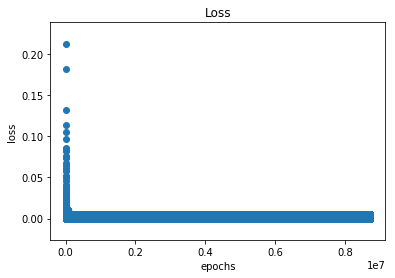

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

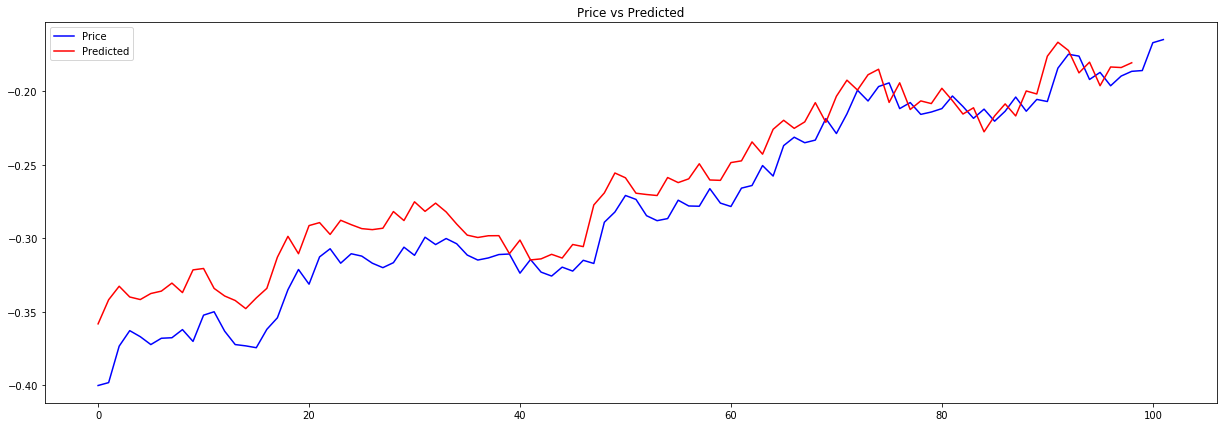

In [24]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()